In [1]:
#%%
# Python code to graph the analysis of 4MOST forecast files
# -*- coding: utf-8 -*-

import numpy as np
import copy
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
import matplotlib.animation as animation
import matplotlib as mpl
import scipy.stats as stats

# Code to plot transfer functions from camb

global FILEPATH
#FILEPATH = "/Users/cb607/Documents/Power_Spectrum_Calc"
FILEPATH = "/cosma8/data/dp203/dc-brow6"
# Colourblind friendly colour cycle - Bang Wong, Points of view: Colour Blindness, Nature 8, 441 (2011)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['xkcd:orange','xkcd:sky blue','xkcd:bluish green','xkcd:reddish purple','xkcd:blue','xkcd:vermillion','xkcd:yellow','xkcd:black'])

# Publication quality graphs
def set_pub():
    plt.rcParams.update({
        "font.size": 20,        # font size
        "figure.figsize":(9, 8),# figure size
        "lines.linewidth": 2,
        "font.weight": "bold",  # bold fonts
        "text.usetex": True,
        "font.family": 'serif'
    })

# conNumLim = 10000, rcond = condNumMultiplier/conNumLim
condNumMultiplier = 10.**(-8)


#############
# FUNCTIONS #
#############


class ParameterPlotter:
    """
    ###############################################
    Parameter Plotter Class
    Generates plots from loaded in Fisher matrices.
    ###############################################

    fisherMatrixArray(array-like(2d array-like(float)))
        Array of Fisher Matrices to be plotted.
    """

    def __init__(self, fisherMatrixArray):
        self.modelNumber = len(fisherMatrixArray)
        self.fisherMatrices = fisherMatrixArray

    def contourPlot(self, paramNames, paramValues, axLimSet, axLims, edgecolours, colours, legend, sigma=2, title=""):
        num = len(paramNames)
        conNumLim = 10000.
        invertedFisherMatrices = []
        for i in range(self.modelNumber):
            if(np.linalg.cond(self.fisherMatrices[i], 'fro')>conNumLim):
                invertedFisherMatrices.append(np.linalg.pinv(self.fisherMatrices[i], rcond=condNumMultiplier/conNumLim, hermitian=True))
            else:
                invertedFisherMatrices.append(np.linalg.inv(self.fisherMatrices[i]))
        for i in range(self.modelNumber):
            for j in range(num):
                if(axLimSet[j]==False):
                    axLims[j][1] = max(paramValues[j]+(sigma*(invertedFisherMatrices[i][j][j]**0.5)), axLims[j][1])
                    axLims[j][0] = min(paramValues[j]-(sigma*(invertedFisherMatrices[i][j][j]**0.5)), axLims[j][0])
        fig, axs = plt.subplots(num, num, gridspec_kw={'hspace':0, 'wspace':0}, figsize=(9,8))
        set_pub()
        for i in range(num):
            for j in range(num):
                if(i==0 and i!=j):  # LHS contours
                    axs[j,i].set_ylabel(paramNames[j])
                if(j==num-1 and i!=j):  # Bottom contours
                    axs[j,i].set_xlabel(paramNames[i])
                if(j<i):  # Outside the main triangle
                    if(j==0 and i==num-1):  # Top right corner (legend)
                        axs[j,i].axis('off')
                    else:  # Delete rest
                        fig.delaxes(axs[j,i])

                elif(i==j):  # Along main diagonal (gaussian)
                    for k in range(self.modelNumber):
                        self.plotGaussian(axs=axs[j,i], mu=paramValues[i], sigma=(invertedFisherMatrices[k][i][i]**0.5), color=edgecolours[k])
                    axs[j,i].set_xlim([axLims[i][0], axLims[i][1]])
                    axs[j,i].set_ylim([0, 1.2])
                    axs[j,i].locator_params(nbins=3) # Sets number of ticks per gaussian plot
                    axs[j,i].tick_params(axis="x", direction="in", top=False, bottom=True, left=False, right=False, labelrotation=270) # Set tick location
                    axs[j,i].tick_params(axis="y", direction="in", top=False, bottom=True, left=False, right=False)
                    if(j!=num-1):  # Not bottom
                        axs[j,i].set_xticklabels([])
                    else:  # Bottom
                        axs[j,i].set_xlabel(paramNames[i])
                    axs[j,i].set_yticklabels([])  # Blank vertical labels

                else:  # Inside plot triangle (contours)
                    axs[j,i].axvline(paramValues[i], c='grey', lw=1)
                    axs[j,i].axhline(paramValues[j], c='grey', lw=1)
                    for k in range(self.modelNumber):
                        self.plotParameterEllipse(invertedFisher=invertedFisherMatrices[k], param1=i, param2=j, xCent=paramValues[i], yCent=paramValues[j],
                            ax=axs[j,i], n_std=2, label=r'$2\sigma$', facecolor=colours[k], edgecolor=edgecolours[k], alpha=0.4)
                        self.plotParameterEllipse(invertedFisher=invertedFisherMatrices[k], param1=i, param2=j, xCent=paramValues[i], yCent=paramValues[j],
                            ax=axs[j,i], n_std=1, label=r'$1\sigma$', facecolor=colours[k], edgecolor=edgecolours[k], alpha=0.6, linestyle='--')
                    axs[j,i].set_xlim([axLims[i][0], axLims[i][1]])
                    axs[j,i].set_ylim([axLims[j][0], axLims[j][1]])
                    axs[j,i].locator_params(nbins=3) # Sets number of ticks per contour plot
                    axs[j,i].tick_params(direction="in", top=True, bottom=True, left=True, right=True)
                    if(i!=0):  # Not LHS
                        axs[j,i].set_yticklabels([])
                    if(j!=num-1):  # Not Bottom
                        axs[j,i].set_xticklabels([])
                    else:  # Bottom
                        axs[j,i].tick_params(axis="x", direction="in", top=True, bottom=True, left=True, right=True, labelrotation=270)

        patchList = []
        for i in range(self.modelNumber):
            patchList.append(mpatches.Patch(facecolor=colours[i], edgecolor=edgecolours[i], label=legend[i]))
        axs[0][num-1].legend(handles=patchList)
        if(title!=""):
            plt.savefig(title)
        plt.show()

    def plotGaussian(self, axs, mu, sigma, **kwargs):
        x=np.linspace(mu-3*sigma, mu+3*sigma, 100)
        y=stats.norm.pdf(x, mu, sigma)
        ymax=max(y)
        y=y/ymax
        axs.plot(x, y, **kwargs)

    def plotParameterEllipse(self, invertedFisher, param1, param2, xCent, yCent, ax, n_std=3.0, facecolor='none', **kwargs):
        covMatrix = []
        for i in range(2):
            covMatrixRow = []
            covMatrixRow.append(1)
            covMatrixRow.append(1)
            covMatrix.append(covMatrixRow)
        covMatrix[0][0] = invertedFisher[param1][param1]
        covMatrix[0][1] = invertedFisher[param1][param2]
        covMatrix[1][0] = invertedFisher[param2][param1]
        covMatrix[1][1] = invertedFisher[param2][param2]
        pearson = covMatrix[0][1]/np.sqrt(covMatrix[0][0] * covMatrix[1][1])
        # Using a special case to obtain the eigenvalues of this
        # two-dimensionl dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)

        # Calculating the stdandard deviation of x from
        # the squareroot of the variance and multiplying
        # with the given number of standard deviations.
        scale_x = np.sqrt(covMatrix[0][0]) * n_std

        # calculating the stdandard deviation of y ...
        scale_y = np.sqrt(covMatrix[1][1]) * n_std

        transf = transforms.Affine2D()         .rotate_deg(45)         .scale(scale_x, scale_y)         .translate(xCent, yCent)

        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def subPlot(self, params, paramNames, paramValues, axLimSet, axLims, edgecolours, colours, legend, sigma=2, title=""):
        num = len(params)
        conNumLim = 10000.
        invertedFisherMatrices = []
        for i in range(self.modelNumber):
            if(np.linalg.cond(self.fisherMatrices[i])>conNumLim):
                invertedFisherMatrices.append(np.linalg.pinv(self.fisherMatrices[i], rcond=condNumMultiplier/conNumLim, hermitian=True))
            else:
                invertedFisherMatrices.append(np.linalg.inv(self.fisherMatrices[i]))
        for i in range(self.modelNumber):
            for j in range(num):
                if(axLimSet[j]==False):
                    axLims[j][1] = max(paramValues[j]+(sigma*(invertedFisherMatrices[i][params[j]][params[j]]**0.5)), axLims[j][1])
                    axLims[j][0] = min(paramValues[j]-(sigma*(invertedFisherMatrices[i][params[j]][params[j]]**0.5)), axLims[j][0])
        fig, axs = plt.subplots(num, num, gridspec_kw={'hspace':0.1, 'wspace':0.1}, figsize=(9,8))
        for i in range(num):
            for j in range(num):
                if(i==0 and i!=j):
                    axs[j,i].set_ylabel(paramNames[j], fontsize=20)
                if(j==num-1 and i!=j):
                    axs[j,i].set_xlabel(paramNames[i], fontsize=20)
                if(j<i):
                    if(j==0 and i==num-1):
                        axs[j,i].axis('off')
                    else:
                        fig.delaxes(axs[j,i])
                elif(i==j):
                    for k in range(self.modelNumber):
                        self.plotGaussian(axs=axs[j,i], mu=paramValues[i], sigma=(invertedFisherMatrices[k][params[i]][params[i]]**0.5), color=edgecolours[k])
                    axs[j,i].set_xlim([axLims[i][0], axLims[i][1]])
                    axs[j,i].set_ylim([0, 1.2])
                    axs[j,i].locator_params(nbins=3) # Sets number of ticks
                    axs[j,i].tick_params(axis="x", direction="in", top=False, bottom=True, left=False, right=False, labelrotation=270, labelsize=18, length=6, width=2) # Set tick location
                    axs[j,i].tick_params(axis="y", direction="in", top=False, bottom=True, left=False, right=False, labelsize=18, length=6, width=2)
                    if(j!=num-1):
                        axs[j,i].set_xticklabels([])
                    else:
                        axs[j,i].set_xlabel(paramNames[i], fontsize=20)
                    axs[j,i].set_yticklabels([])

                else:
                    axs[j,i].axvline(paramValues[i], c='grey', lw=1)
                    axs[j,i].axhline(paramValues[j], c='grey', lw=1)
                    for k in range(self.modelNumber):
                        self.plotParameterEllipse(invertedFisher=invertedFisherMatrices[k], param1=params[i], param2=params[j], xCent=paramValues[i], yCent=paramValues[j],
                            ax=axs[j,i], n_std=2, label=r'$2\sigma$', facecolor=colours[k], edgecolor=edgecolours[k], alpha=0.4)
                        self.plotParameterEllipse(invertedFisher=invertedFisherMatrices[k], param1=params[i], param2=params[j], xCent=paramValues[i], yCent=paramValues[j],
                            ax=axs[j,i], n_std=1, label=r'$1\sigma$', facecolor=colours[k], edgecolor=edgecolours[k], alpha=0.6, linestyle='--')
                    axs[j,i].set_xlim([axLims[i][0], axLims[i][1]])
                    axs[j,i].set_ylim([axLims[j][0], axLims[j][1]])
                    axs[j,i].locator_params(nbins=3) # Sets number of ticks
                    axs[j,i].tick_params(direction="in", top=True, bottom=True, left=True, right=True, labelsize=18, length=6, width=2)
                    axs[j,i].tick_params(direction="in", which="minor", top=True, bottom=True, left=True, right=True)
                    if(i!=0):
                        axs[j,i].set_yticklabels([])
                    if(j!=num-1):
                        axs[j,i].set_xticklabels([])
                    else:  # Bottom
                        axs[j,i].tick_params(axis="x", direction="in", top=True, bottom=True, left=True, right=True, labelrotation=270, labelsize=20, length=6, width=2)
        patchList = []
        for i in range(self.modelNumber):
            patchList.append(mpatches.Patch(facecolor=colours[i], edgecolor=edgecolours[i], label=legend[i]))
        axs[0][num-1].legend(handles=patchList, prop={'size': 20})
        if(title!=""):
            plt.savefig(title)
        plt.show()
        
    def singleContourPlot(self, params, paramNames, paramValues, axLimSet, axLims, edgecolours, colours, legend, sigma=2, title="", text=""):
        num = len(params)
        conNumLim = 10000.
        invertedFisherMatrices = []
        for i in range(self.modelNumber):
            if(np.linalg.cond(self.fisherMatrices[i])>conNumLim):
                invertedFisherMatrices.append(np.linalg.pinv(self.fisherMatrices[i], rcond=condNumMultiplier/conNumLim, hermitian=True))
            else:
                invertedFisherMatrices.append(np.linalg.inv(self.fisherMatrices[i]))
        for i in range(self.modelNumber):
            for j in range(2):
                if(axLimSet[j]==False):
                    axLims[j][1] = max(paramValues[j]+(sigma*(invertedFisherMatrices[i][params[j]][params[j]]**0.5)), axLims[j][1])
                    axLims[j][0] = min(paramValues[j]-(sigma*(invertedFisherMatrices[i][params[j]][params[j]]**0.5)), axLims[j][0])
        fig, axs = plt.subplots(1, 1, gridspec_kw={'hspace':0.1, 'wspace':0.1}, figsize=(9,8))
        axs.set_ylabel(paramNames[1], fontsize=20)
        axs.set_xlabel(paramNames[0], fontsize=20)
        axs.axvline(paramValues[0], c='grey', lw=1)
        axs.axhline(paramValues[1], c='grey', lw=1)
        for k in range(self.modelNumber):
            self.plotParameterEllipse(invertedFisher=invertedFisherMatrices[k], param1=params[0], param2=params[1], xCent=paramValues[0], yCent=paramValues[1],
                            ax=axs, n_std=2, label=r'$2\sigma$', facecolor=colours[k], edgecolor=edgecolours[k], alpha=0.4)
            self.plotParameterEllipse(invertedFisher=invertedFisherMatrices[k], param1=params[0], param2=params[1], xCent=paramValues[0], yCent=paramValues[1],
                            ax=axs, n_std=1, label=r'$1\sigma$', facecolor=colours[k], edgecolor=edgecolours[k], alpha=0.6, linestyle='--')
        axs.set_xlim([axLims[0][0], axLims[0][1]])
        axs.set_ylim([axLims[1][0], axLims[1][1]])
        axs.locator_params(nbins=3) # Sets number of ticks
        axs.tick_params(direction="in", top=True, bottom=True, left=True, right=True, labelsize=20, length=6, width=2)
        axs.tick_params(direction="in", which="minor", top=True, bottom=True, left=True, right=True)
        axs.tick_params(axis="x", direction="in", top=True, bottom=True, left=True, right=True, labelrotation=270, labelsize=20, length=6, width=2)
        axs.text(axLims[0][1] - (7*sigma*(invertedFisherMatrices[0][params[0]][params[0]]**0.5))/10, axLims[1][0] + (2*sigma*(invertedFisherMatrices[0][params[1]][params[1]]**0.5))/10, text, bbox={'facecolor':'none'}, fontsize=18)#, ha='left', transform=axs.transAxes)
        patchList = []
        for i in range(self.modelNumber):
            patchList.append(mpatches.Patch(facecolor=colours[i], edgecolor=edgecolours[i], label=legend[i]))
        axs.legend(handles=patchList, prop={'size': 20}, loc='upper left')
        if(title!=""):
            plt.savefig(title)
        plt.show()



In [3]:
class graphModel:
    """
    ########################################################
    Graphing class
    Holds parameters to be called when graphing corner plots
    ########################################################
    """
    def __init__(self, name, pNames, pValues, axLimSet, axLims, subIndx, sigma8, s8Indx, s8SubIndx):
        self.name = name
        self.pNames = pNames
        self.pValues = pValues
        self.axLimSet = axLimSet
        self.axLims = axLims
        self.subIndx = subIndx
        self.pNamesSub = pNames[subIndx]
        self.pValuesSub = pValues[subIndx]
        self.axLimSetSub = axLimSet[subIndx]
        self.axLimsSub = axLims[subIndx]
        s8pValues = np.copy(pValues)
        s8pNames = np.copy(pNames)
        s8pSet = np.copy(axLimSet)
        s8pLims = np.copy(axLims)
        for i in range(len(pValues)):
            if(i==s8Indx):
                s8pValues[i] = sigma8[0]
                s8pNames[i] = "$\sigma_8$"
                s8pLims[i] = [sigma8[0], sigma8[0]]
        self.s8pNames = s8pNames
        self.s8pValues = s8pValues
        self.s8axLimSet = s8pSet
        self.s8axLims = s8pLims
        self.s8SubIndx = s8SubIndx
        self.s8pNamesSub = s8pNames[s8SubIndx]
        self.s8pValuesSub = s8pValues[s8SubIndx]
        self.s8axLimSetSub = s8pSet[s8SubIndx]
        self.s8axLimsSub = s8pLims[s8SubIndx]
        

In [5]:
# Preparation for graphModel classes

# Parameters for setting axis limits
h=0.6766
As=1.0
ns=0.9665
omegaM=0.3111
OmegaB=0.02242/(0.6766*0.6766)
omegaB=0.02242
fnu=0.12/(93.14*0.3111*0.6766*0.6766)
Neff=3.046
tau=0.0561
w0=-1
wa=0
OmC = omegaM - omegaB - (fnu*omegaM*h*h)
Mnu=93.14*fnu*omegaM*h*h
conNumLim = 10000.

# Load Fisher matrices which include neutrino parameters (to avoid graphing mass<0eV)
nuwCDMFisher = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLennuwCDM.dat')
nuLCDMFisher = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlancknuLCDM.dat')
DESnuwCDMFisher = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFullDESLensDESnuwCDM.dat')
DESnuLCDMFisher = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFullDESLensDESnuLCDM.dat')

# List of models with original parameters and their parameter basis shifts,
# plus setting up models for graphModel

# nuwCDM
# h, OmB, OmM, fnu, As, ns, Neff, tau, w0, wa
# wc, wb, OmM, mnu, As, ns, Neff, tau, w0, wa
nuwPlotter = ParameterPlotter(fisherMatrixArray=[nuwCDMFisher])
nuwCDMParams = np.array(["$\omega_c$","$\omega_b$","$\Omega_M$","$\Sigma m_{\\nu}$","$A_s$","$n_s$","$N_{eff}$","$\\tau$","$w_0$","$w_a$"])
nuwCDMVals = np.array([OmC*h*h, omegaB, omegaM, Mnu, As, ns, Neff, tau, w0, wa])
if(np.linalg.cond(nuwPlotter.fisherMatrices[0], 'fro')>conNumLim):
    nuwinvertFisher = np.linalg.pinv(nuwPlotter.fisherMatrices[0], rcond=condNumMultiplier/conNumLim, hermitian=True)
else:
    nuwinvertFisher = np.linalg.inv(nuwPlotter.fisherMatrices[0])
nuwCDMMnuDev = 2.5*(nuwinvertFisher[3][3]**0.5)
nuwCDMSet = np.array([False, False, False, True, False, False, False, False, False, False])
nuwCDMLims = np.array([[OmC*h*h, OmC*h*h], [omegaB, omegaB], [omegaM, omegaM], [0, Mnu+nuwCDMMnuDev], [As, As], [ns, ns], [Neff, Neff], [tau, tau], [w0, w0], [wa, wa]])
nuwCDMSub = np.array([1,2,3,4,6,8,9])
nuwCDMS8Indx = 4
nuwCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8nuwCDM.dat')
nuwCDMS8Sub = np.array([2,3,4,6,8,9])

# nuLCDM
# h, OmB, OmM, fnu, As, ns, Neff, tau
# wc, wb, OmM, mnu, As, ns, Neff, tau
nuLPlotter = ParameterPlotter(fisherMatrixArray=[nuLCDMFisher])
nuLCDMParams = np.array(["$\omega_c$","$\omega_b$","$\Omega_M$","$\Sigma m_{\\nu}$","$A_s$","$n_s$","$N_{eff}$","$\\tau$"])
nuLCDMVals = np.array([OmC*h*h, omegaB, omegaM, Mnu, As, ns, Neff, tau])
if(np.linalg.cond(nuLPlotter.fisherMatrices[0], 'fro')>conNumLim):
    nuLinvertFisher = np.linalg.pinv(nuLPlotter.fisherMatrices[0], rcond=condNumMultiplier/conNumLim, hermitian=True)
else:
    nuLinvertFisher = np.linalg.inv(nuLPlotter.fisherMatrices[0])
nuLCDMMnuDev = 2.5*(nuLinvertFisher[3][3]**0.5)
nuLCDMSet = np.array([False, False, False, True, False, False, False, False])
nuLCDMLims = np.array([[OmC*h*h, OmC*h*h], [omegaB, omegaB], [omegaM, omegaM], [0, Mnu+nuLCDMMnuDev], [As, As], [ns, ns], [Neff, Neff], [tau, tau]])
nuLCDMSub = np.array([1,2,3,4,6])
nuLCDMS8Indx = 4
nuLCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8nuLCDM.dat')
nuLCDMS8Sub = np.array([1,2,3,4,6])

# wCDM
# h, OmB, OmM, As, ns, tau, w0, wa
# wc, wb, OmM, As, ns, tau, w0, wa
wCDMParams = np.array(["$\omega_c$","$\omega_b$","$\Omega_M$","$A_s$","$n_s$","$\\tau$","$w_0$","$w_a$"])
wCDMVals = np.array([OmC*h*h, omegaB, omegaM, As, ns, tau, w0, wa])
wCDMSet = np.array([False, False, False, False, False, False, False, False])
wCDMLims = np.array([[OmC*h*h, OmC*h*h], [omegaB, omegaB], [omegaM, omegaM], [As, As], [ns, ns], [tau, tau], [w0, w0], [wa, wa]])
wCDMSub = np.array([1,2,4,6,7])
wCDMS8Indx = 3
wCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8wCDM.dat')
wCDMS8Sub = np.array([1,2,4,6,7])

# LCDM
# h, OmB, OmM, As, ns, tau
# wc, wb, OmM, As, ns, tau
LCDMParams = np.array(["$\omega_c$","$\omega_b$","$\Omega_M$","$A_s$","$n_s$","$\\tau$"])
LCDMVals = np.array([OmC*h*h, omegaB, omegaM, As, ns, tau])
LCDMSet = np.array([False, False, False, False, False, False])
LCDMLims = np.array([[OmC*h*h, OmC*h*h], [omegaB, omegaB], [omegaM, omegaM], [As, As], [ns, ns], [tau, tau]])
LCDMSub = np.array([1,2,3])
LCDMS8Indx = 3
LCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8LCDM.dat')
LCDMS8Sub = np.array([2,3])

# DES nuwCDM
# h, OmB, OmM, fnu, As, ns, w0
# h, OmB, OmM, mnu, As, ns, w0
DESnuwPlotter = ParameterPlotter(fisherMatrixArray=[DESnuwCDMFisher])
DESnuwCDMParams = np.array(["$h$","$\Omega_b$","$\Omega_M$","$\Sigma m_{\\nu}$","$A_s$","$n_s$","$w_0$"])
DESnuwCDMVals = np.array([h, OmegaB, omegaM, Mnu, As, ns, w0])
if(np.linalg.cond(DESnuwPlotter.fisherMatrices[0], 'fro')>conNumLim):
    DESnuwinvertFisher = np.linalg.pinv(DESnuwPlotter.fisherMatrices[0], rcond=condNumMultiplier/conNumLim, hermitian=True)
else:
    DESnuwinvertFisher = np.linalg.inv(DESnuwPlotter.fisherMatrices[0])
DESnuwCDMMnuDev = 2.5*(DESnuwinvertFisher[3][3]**0.5)
DESnuwCDMSet = np.array([False, False, False, True, False, False, False])
DESnuwCDMLims = np.array([[h, h], [OmegaB, OmegaB], [omegaM, omegaM], [0, Mnu+DESnuwCDMMnuDev], [As, As], [ns, ns], [w0, w0]])
DESnuwCDMSub = np.array([0,1,2,3,4,5,6])
DESnuwCDMS8Indx = 4
DESnuwCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8DESnuwCDM.dat')
DESnuwCDMS8Sub = np.array([0,1,2,3,4,5,6])

# DES nuLCDM
# h, OmB, OmM, fnu, As, ns
# h, OmB, OmM, mnu, As, ns
DESnuLPlotter = ParameterPlotter(fisherMatrixArray=[DESnuLCDMFisher])
DESnuLCDMParams = np.array(["$h$","$\Omega_b$","$\Omega_M$","$\Sigma m_{\\nu}$","$A_s$","$n_s$"])
DESnuLCDMVals = np.array([h, OmegaB, omegaM, Mnu, As, ns])
if(np.linalg.cond(DESnuLPlotter.fisherMatrices[0], 'fro')>conNumLim):
    DESnuLinvertFisher = np.linalg.pinv(DESnuLPlotter.fisherMatrices[0], rcond=condNumMultiplier/conNumLim, hermitian=True)
else:
    DESnuLinvertFisher = np.linalg.inv(DESnuLPlotter.fisherMatrices[0])
DESnuLCDMMnuDev = 2.5*(DESnuLinvertFisher[3][3]**0.5)
DESnuLCDMSet = np.array([False, False, False, True, False, False])
DESnuLCDMLims = np.array([[h, h], [OmegaB, OmegaB], [omegaM, omegaM], [0, Mnu+DESnuLCDMMnuDev], [As, As], [ns, ns]])
DESnuLCDMSub = np.array([0,1,2,3,4,5])
DESnuLCDMS8Indx = 4
DESnuLCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8DESnuLCDM.dat')
DESnuLCDMS8Sub = np.array([0,1,2,3,4,5])

# DES 3x2pt wCDM
# OmM, As, w
# OmM, As, w
DES3x2ptwCDMParams = np.array(["$\Omega_M$","$A_s$","$w_0$"])
DES3x2ptwCDMVals = np.array([omegaM, As, w0])
DES3x2ptwCDMSet = np.array([False, False, False])
DES3x2ptwCDMLims = np.array([[omegaM, omegaM], [As, As], [w0, w0]])
DES3x2ptwCDMSub = np.array([0,1,2])
DES3x2ptwCDMS8Indx = 1
DES3x2ptwCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8DES3x2ptwCDM.dat')
DES3x2ptwCDMS8Sub = np.array([0,1,2])

# DES 3x2pt LCDM
# OmM, As
# OmM, As
DES3x2ptLCDMParams = np.array(["$\Omega_M$","$A_s$"])
DES3x2ptLCDMVals = np.array([omegaM, As])
DES3x2ptLCDMSet = np.array([False, False])
DES3x2ptLCDMLims = np.array([[omegaM, omegaM], [As, As]])
DES3x2ptLCDMSub = np.array([0,1])
DES3x2ptLCDMS8Indx = 1
DES3x2ptLCDMS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/sigma8DES3x2ptLCDM.dat')
DES3x2ptLCDMS8Sub = np.array([0,1])


1.188331469146881


In [6]:
# Make graphModel classes

nuwCDMGraph = graphModel(name=r"$\nu$wCDM", pNames=nuwCDMParams, pValues=nuwCDMVals, axLimSet=nuwCDMSet, 
                         axLims=nuwCDMLims, subIndx=nuwCDMSub, sigma8=nuwCDMS8, s8Indx=nuwCDMS8Indx, s8SubIndx=nuwCDMS8Sub)
nuLCDMGraph = graphModel(name=r"$\nu \Lambda$CDM", pNames=nuLCDMParams, pValues=nuLCDMVals, axLimSet=nuLCDMSet, 
                         axLims=nuLCDMLims, subIndx=nuLCDMSub, sigma8=nuLCDMS8, s8Indx=nuLCDMS8Indx, s8SubIndx=nuLCDMS8Sub)
wCDMGraph = graphModel(name="wCDM", pNames=wCDMParams, pValues=wCDMVals, axLimSet=wCDMSet, 
                         axLims=wCDMLims, subIndx=wCDMSub, sigma8=wCDMS8, s8Indx=wCDMS8Indx, s8SubIndx=wCDMS8Sub)
LCDMGraph = graphModel(name=r"$\Lambda$CDM", pNames=LCDMParams, pValues=LCDMVals, axLimSet=LCDMSet, 
                         axLims=LCDMLims, subIndx=LCDMSub, sigma8=LCDMS8, s8Indx=LCDMS8Indx, s8SubIndx=LCDMS8Sub)
DESnuwCDMGraph = graphModel(name=r"$\nu$wCDM", pNames=DESnuwCDMParams, pValues=DESnuwCDMVals, axLimSet=DESnuwCDMSet, 
                         axLims=DESnuwCDMLims, subIndx=DESnuwCDMSub, sigma8=DESnuwCDMS8, s8Indx=DESnuwCDMS8Indx, s8SubIndx=DESnuwCDMS8Sub)
DESnuLCDMGraph = graphModel(name=r"$\nu \Lambda$CDM", pNames=DESnuLCDMParams, pValues=DESnuLCDMVals, axLimSet=DESnuLCDMSet, 
                         axLims=DESnuLCDMLims, subIndx=DESnuLCDMSub, sigma8=DESnuLCDMS8, s8Indx=DESnuLCDMS8Indx, s8SubIndx=DESnuLCDMS8Sub)
DES3x2ptwCDMGraph = graphModel(name=r"wCDM", pNames=DES3x2ptwCDMParams, pValues=DES3x2ptwCDMVals, axLimSet=DES3x2ptwCDMSet, 
                         axLims=DES3x2ptwCDMLims, subIndx=DES3x2ptwCDMSub, sigma8=DES3x2ptwCDMS8, s8Indx=DES3x2ptwCDMS8Indx, s8SubIndx=DES3x2ptwCDMS8Sub)
DES3x2ptLCDMGraph = graphModel(name=r"LCDM", pNames=DES3x2ptLCDMParams, pValues=DES3x2ptLCDMVals, axLimSet=DES3x2ptLCDMSet, 
                         axLims=DES3x2ptLCDMLims, subIndx=DES3x2ptLCDMSub, sigma8=DES3x2ptLCDMS8, s8Indx=DES3x2ptLCDMS8Indx, s8SubIndx=DES3x2ptLCDMS8Sub)

In [7]:
# Define functions for plotting Figure of Merit and contour corner plots

def set_pub():
    plt.rcParams.update({
        "font.size": 20,        # font size
        "figure.figsize":(9, 8),# figure size
        "lines.linewidth": 2,
        "font.weight": "bold",  # bold fonts
        "text.usetex": True,
        "font.family": 'serif'
    })

def figureOfMerit(fisherMatrix, param1, param2):
    conNumLim = 10000.
    invertedFisher = np.linalg.pinv(fisherMatrix, rcond=condNumMultiplier/conNumLim, hermitian=True)
    subMatrix = np.array([[invertedFisher[param1][param1], invertedFisher[param1][param2]], [invertedFisher[param2][param1], invertedFisher[param2][param2]]])
    return (1/(np.pi*((6.17*np.linalg.det(subMatrix))**0.5)))

def plotFOM(fisherMatrices, param1, param2, modelNames, colours):
    # Fisher matrices must cover same cosmological model (excluding marginalised params)
    figuresOfMerit = []
    for matrix in fisherMatrices:
        figuresOfMerit.append(figureOfMerit(fisherMatrix=matrix, param1=param1, param2=param2))
    pos = np.arange(len(figuresOfMerit))
    fig, ax = plt.subplots(figsize=(6,6))
    width=0.5
    for i in range(len(pos)):
        ax.bar(pos[i], figuresOfMerit[i], width=width, color=colours[i], label=modelNames[i])
    ax.set_xticklabels([])
    ax.tick_params(axis="x", bottom=False)
    ax.tick_params(axis="y", direction="in", left=True, right=True)
    ax.legend()
    ax.set_ylabel("$w_0$-$w_a$ Figure of Merit")
    plt.show()
    
def plotFOMRatio(fisherMatrices, param1, param2, yLabel, modelNames, colours, x, y, text, perModel=False, duoBar=False, title=""):
    # Fisher matrices must cover same cosmological model (excluding marginalised params)
    figuresOfMerit = []
    barGroups = 0
    print("Figures of Merit:")
    for i in range(len(fisherMatrices)):
        print(figureOfMerit(fisherMatrix=fisherMatrices[i], param1=param1, param2=param2))
    if(perModel):
        for i in range(round(len(fisherMatrices)/2)):
            barGroups = barGroups + 1
            figuresOfMerit.append((figureOfMerit(fisherMatrix=fisherMatrices[2*i], param1=param1, param2=param2)/figureOfMerit(fisherMatrix=fisherMatrices[(2*i)+1], param1=param1, param2=param2))-1)
    else:
        for i in range(round(len(fisherMatrices)-1)):
            barGroups = barGroups + 1
            figuresOfMerit.append((figureOfMerit(fisherMatrix=fisherMatrices[i+1], param1=param1, param2=param2)/figureOfMerit(fisherMatrix=fisherMatrices[0], param1=param1, param2=param2))-1)
    fig, ax = plt.subplots(figsize=(9,8))
    set_pub()
    width=0.35
    pos = np.arange(barGroups)
    if(duoBar):
        figuresOfMeritCon = []
        figuresOfMeritInt = []
        for i in range(len(pos)):
            figuresOfMeritCon.append(figuresOfMerit[2*i])
            figuresOfMeritInt.append(figuresOfMerit[2*i + 1])
        ax.bar(pos-width/2, figuresOfMeritCon, width=width, color=colours[0], alpha=1.0, label="Conservative", zorder=3)
        ax.bar(pos+width/2, figuresOfMeritInt, width=width, color=colours[1], alpha=1.0, label="Optimal", zorder=3)
    else:
        for i in range(len(pos)):
            ax.bar(pos[i], figuresOfMerit[i], width=0.5, color=colours[i], label=modelNames[i])
    ax.set_xticks(pos)
    ax.set_xticklabels(modelNames, fontsize=20)
    ax.plot([pos[0]-1, pos[len(pos)-1]+1], [0,0], "k--")
    ax.set_xlim([pos[0]-0.5, pos[len(pos)-1]+0.5])
    ax.legend(prop={'size': 20})
    
    ax.grid(b=True, which='Major', axis='y', zorder=0)
    ax.text(x, y, text, bbox={'facecolor':'none'}, fontsize=20)
    
    ax.set_ylabel(yLabel, fontsize=20)
    if(title!=""):
        saveName = FILEPATH + "/Graphs/" + title
        plt.savefig(saveName)
    plt.show()
    

def plotFisherMatrices(fisherMatrices, graphModel, legend, colour, edgecolour, precsn="{:.5}", DES=False, extraTxt="", saveName=""):
    
    if(saveName!=""):
        saveName = FILEPATH+"/Graphs/"+saveName
    
    # Initialise plotter for As
    Plotter = ParameterPlotter(fisherMatrixArray=fisherMatrices[0])
    
    # Contour plot parameters
    paramNamesPlot = graphModel.pNames
    paramValuePlot = graphModel.pValues
    axLimSet = graphModel.axLimSet
    axLims = copy.deepcopy(graphModel.axLims)
    
    # Print parameter values for models in LaTex format
    # Table header
    if(DES):
        print(r"Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\")
        fullParamListAs = np.array(["$\Omega_M$","$A_s$","$\Omega_b$","$n_s$","$h$","$w_0$","$\Sigma m_{\\nu}$"])
    else:
        print(r"Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\")
        fullParamListAs = np.array(["$\omega_c$","$\omega_b$","$\Omega_M$","$A_s$","$n_s$","$\\tau$","$\Sigma m_{\\nu}$","$N_{eff}$","$w_0$","$w_a$"])
    print(r"\hline \hline")
    for j in range(len(Plotter.fisherMatrices)):
        # Invert Fisher
        conNumLim = 10000.
        invFisher = np.zeros((np.shape(Plotter.fisherMatrices[j])))
        if(np.linalg.cond(Plotter.fisherMatrices[j], 'fro')>conNumLim):
            invFisher = np.linalg.pinv(Plotter.fisherMatrices[j], rcond=condNumMultiplier/conNumLim, hermitian=True)
        else:
            invFisher = np.linalg.inv(Plotter.fisherMatrices[j])
        # Form string for table entry
        entry = graphModel.name + " & " + legend[j]
        for i in range(len(fullParamListAs)):
            if(fullParamListAs[i] in paramNamesPlot):
                indx = np.where(paramNamesPlot==fullParamListAs[i])[0][0]
                if(DES):
                    entry = entry + r" & $ \pm " + precsn.format(invFisher[indx][indx]**0.5) + r" $"
                else:
                    entry = entry + r" & $ " + precsn.format(invFisher[indx][indx]**0.5) + r" $"
            else:
                entry = entry + r" & $-$"
        print(entry + extraTxt + r" \\")
        print(r"\hline")
    # Contour plot of all parameters
    Plotter.contourPlot(paramNames=paramNamesPlot, paramValues=paramValuePlot, axLimSet=axLimSet, axLims=axLims, edgecolours=edgecolour, colours=colour, legend=legend, sigma=2, title="")
    
    # Contour subplot parameters
    paramsSub = graphModel.subIndx
    paramNamesSub = graphModel.pNamesSub
    paramValueSub = graphModel.pValuesSub
    axLimSetSub = graphModel.axLimSetSub
    axLimsSub = copy.deepcopy(graphModel.axLimsSub)
    
    # Contour plot of subspace of parameters of interest
    Plotter.subPlot(params=paramsSub, paramNames=paramNamesSub, paramValues=paramValueSub, axLimSet=axLimSetSub, axLims=axLimsSub, edgecolours=edgecolour, colours=colour, legend=legend, sigma=2.5, title="")
    
    # Reinitialise plotter for sigma8
    Plotter = ParameterPlotter(fisherMatrixArray=fisherMatrices[1])
    
    # Contour plot parameters
    paramNamesPlot = graphModel.s8pNames
    paramValuePlot = graphModel.s8pValues
    axLimSet = graphModel.s8axLimSet
    axLims = copy.deepcopy(graphModel.s8axLims)
    
    # Print parameter values for models in LaTex format
    # Table header
    if(DES):
        print(r"Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\")
        fullParamLists8 = np.array(["$\Omega_M$","$\sigma_8$","$\Omega_b$","$n_s$","$h$","$w_0$","$\Sigma m_{\\nu}$"])
    else:
        print(r"Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\")
        fullParamLists8 = np.array(["$\omega_c$","$\omega_b$","$\Omega_M$","$\sigma_8$","$n_s$","$\\tau$","$\Sigma m_{\\nu}$","$N_{eff}$","$w_0$","$w_a$"])
    print(r"\hline \hline")
    for j in range(len(Plotter.fisherMatrices)):
        # Invert Fisher
        conNumLim = 10000.
        invFisher = np.zeros((np.shape(Plotter.fisherMatrices[j])))
        if(np.linalg.cond(Plotter.fisherMatrices[j], 'fro')>conNumLim):
            invFisher = np.linalg.pinv(Plotter.fisherMatrices[j], rcond=condNumMultiplier/conNumLim, hermitian=True)
        else:
            invFisher = np.linalg.inv(Plotter.fisherMatrices[j])
        # Form string for table entry
        entry = graphModel.name + " & " + legend[j]
        for i in range(len(fullParamLists8)):
            if(fullParamLists8[i] in paramNamesPlot):
                indx = np.where(paramNamesPlot==fullParamLists8[i])[0][0]
                if(DES):
                    entry = entry + r" & $ \pm " + precsn.format(invFisher[indx][indx]**0.5) + r" $"
                else:
                    entry = entry + r" & $ " + precsn.format(invFisher[indx][indx]**0.5) + r" $"
            else:
                entry = entry + r" & $-$"
        print(entry + extraTxt + r" \\")
        print(r"\hline")
            
    # Contour plot of all sigma8 parameters
    Plotter.contourPlot(paramNames=paramNamesPlot, paramValues=paramValuePlot, axLimSet=axLimSet, axLims=axLims, edgecolours=edgecolour, colours=colour, legend=legend, sigma=2, title="")
    
    # Contour subplot parameters
    paramsSub = graphModel.s8SubIndx
    paramNamesSub = graphModel.s8pNamesSub
    paramValueSub = graphModel.s8pValuesSub
    axLimSetSub = graphModel.s8axLimSetSub
    axLimsSub = copy.deepcopy(graphModel.s8axLimsSub)
    
    # Contour plot of subspace of parameters of interest
    if(len(paramsSub)>2):
        Plotter.subPlot(params=paramsSub, paramNames=paramNamesSub, paramValues=paramValueSub, axLimSet=axLimSetSub, axLims=axLimsSub, edgecolours=edgecolour, colours=colour, legend=legend, sigma=2.5, title=saveName)
    else:  # If corner plot is 2 parameters, don't include Gaussians
        Plotter.singleContourPlot(params=paramsSub, paramNames=paramNamesSub, paramValues=paramValueSub, axLimSet=axLimSetSub, axLims=axLimsSub, edgecolours=edgecolour, colours=colour, legend=legend, sigma=2.5, title=saveName, text="$\Lambda$CDM")


Figures of Merit:
1.8450755139421615
1.8185342186414575
1.2377700467114023
1.1869284492836687
2.3525067772228327
2.259165629387617
[0 1 2]


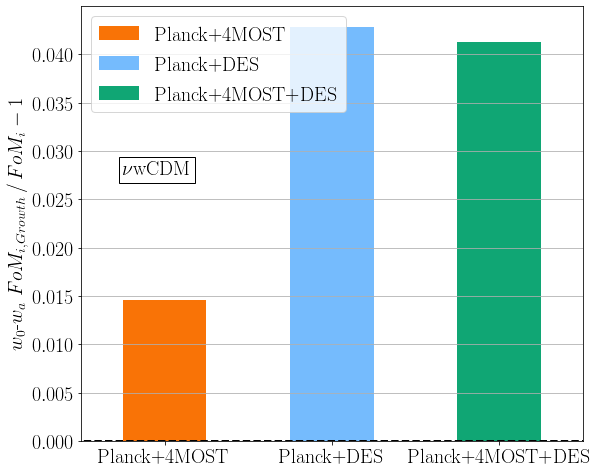

In [22]:
# FIGURES OF MERIT

FisherMatPlanck = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanckLCDM.dat')

model='nuwCDM'

FisherMatGalCon = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+model+'.dat')
FisherMatLensCon = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+model+'.dat')
FisherMatCompleteCon = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+model+'.dat')

dataType = 'Growth'
FisherMatPlanckLimber = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+dataType+model+'.dat')
FisherMatGalConLimber = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+dataType+model+'.dat')
FisherMatLensConLimber = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+dataType+model+'.dat')
FisherMatCompleteConLimber = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+dataType+model+'.dat')


#FOMList = [FisherMatPlanck, FisherMatGalCon, FisherMatLensCon, FisherMatCompleteCon]
FOMList = [FisherMatGalConLimber, FisherMatGalCon, FisherMatLensConLimber, FisherMatLensCon, FisherMatCompleteConLimber, FisherMatCompleteCon]

#########################
# parameter list reminder

# nuwCDM:
# wc, wb, OmM, mnu, s8, ns, Neff, tau, w0, wa

# LCDM:
# wc, wb, OmM, s8, ns, tau

# DESnuwCDM:
# h, Omb, OmM, mnu, s8, ns, w0

# DESnuLCDM:
# h, Omb, OmM, mnu, s8, ns
#########################

names = ["Planck+4MOST", "Planck+DES", "Planck+4MOST+DES"]
yLabel = "$w_0$-$w_a$   $FoM_{i, Growth} \, / \, FoM_{i} - 1$"
# Uncomment title name when ready to save graph as title
title=""
#title="FoM"+model+"w0wa"+dataType+".png"
# x=0.85 OR 0.75 (Depending on length)
plotFOMRatio(fisherMatrices=FOMList, param1=8, param2=9, yLabel=yLabel, modelNames=names, colours=['xkcd:orange','xkcd:sky blue','xkcd:bluish green'], x=0.75-1, y=0.0275, text="$\\nu$wCDM", perModel=True, title=title)


Initialising plotter.



 ### TOY MODEL ### 





 Spec 3x2pt vs. Photo 3x2pt // DES LCDM


Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & Toy Model 3x2pt: Photometric & $ \pm 0.006 $ & $ \pm 0.133 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 3x2pt: Spectroscopic & $ \pm 0.005 $ & $ \pm 0.101 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


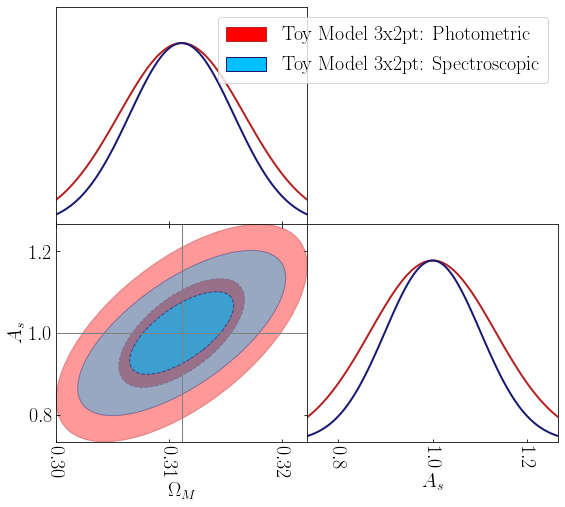

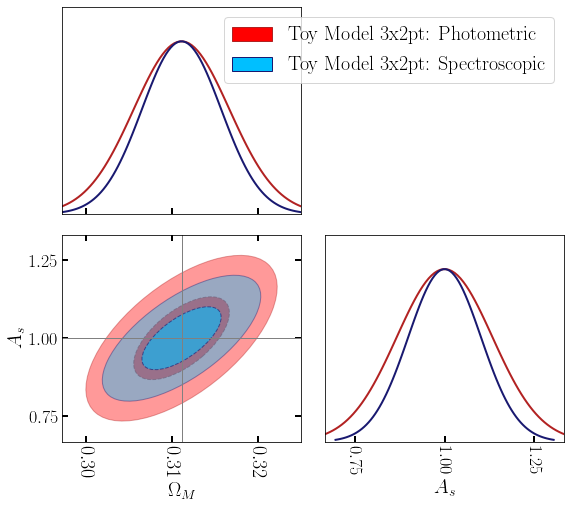

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & Toy Model 3x2pt: Photometric & $ \pm 0.006 $ & $ \pm 0.060 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 3x2pt: Spectroscopic & $ \pm 0.005 $ & $ \pm 0.047 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


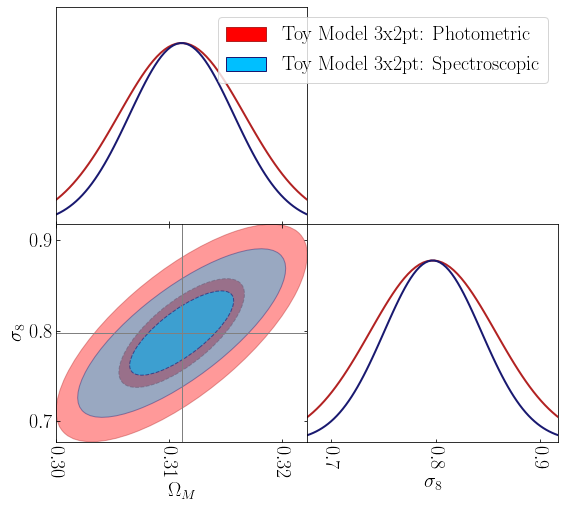

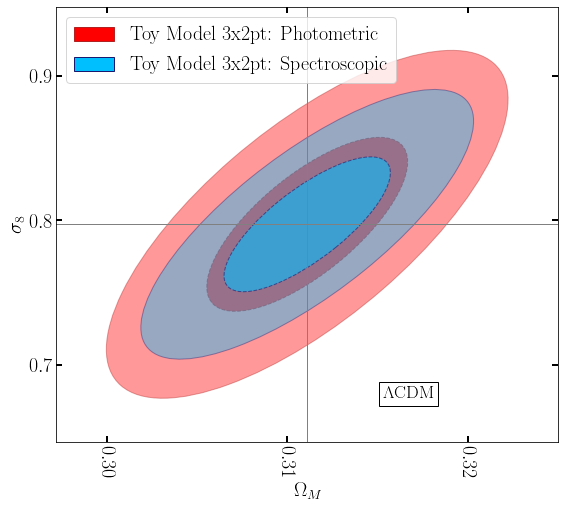




 Spec 1x2pt vs. LSST 1x2pt vs. DES 1x2pt // DES LCDM


Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & Toy Model 1x2pt: DES & $ \pm 0.094 $ & $ \pm 1.445 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 1x2pt: LSST & $ \pm 0.080 $ & $ \pm 1.216 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 1x2pt: Spectroscopic & $ \pm 0.061 $ & $ \pm 1.032 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


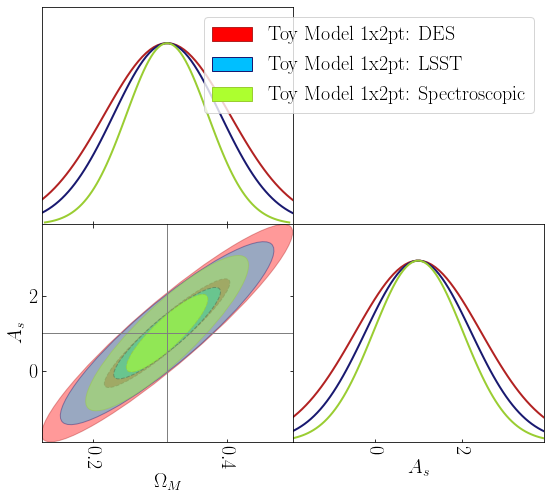

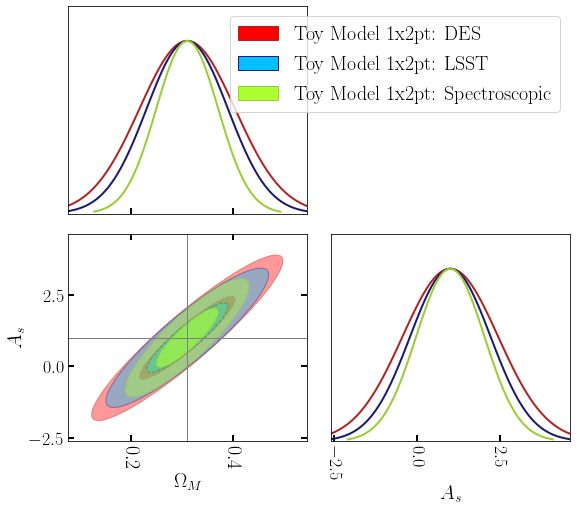

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & Toy Model 1x2pt: DES & $ \pm 0.094 $ & $ \pm 0.745 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 1x2pt: LSST & $ \pm 0.080 $ & $ \pm 0.625 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 1x2pt: Spectroscopic & $ \pm 0.061 $ & $ \pm 0.516 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


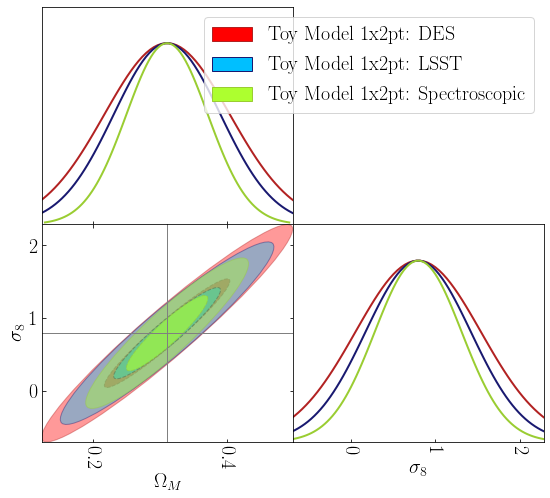

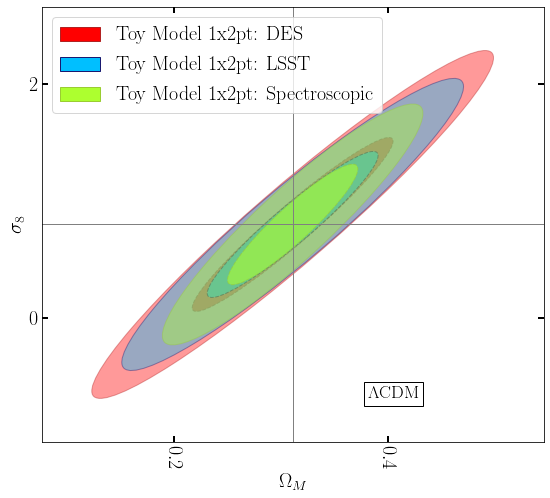




 Optimal 1x2pt vs. No multiplicative bias 1x2pt vs. Full 1x2pt // DES LCDM


Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & Toy Model 1x2pt: Full & $ \pm 0.094 $ & $ \pm 1.445 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 1x2pt: -m & $ \pm 0.032 $ & $ \pm 0.220 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 1x2pt: Optimal & $ \pm 0.004 $ & $ \pm 0.054 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


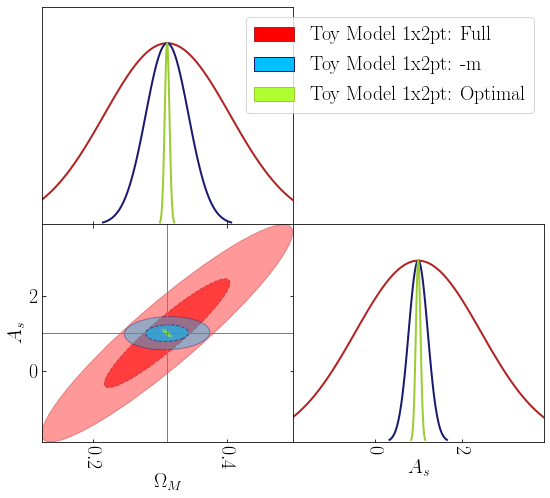

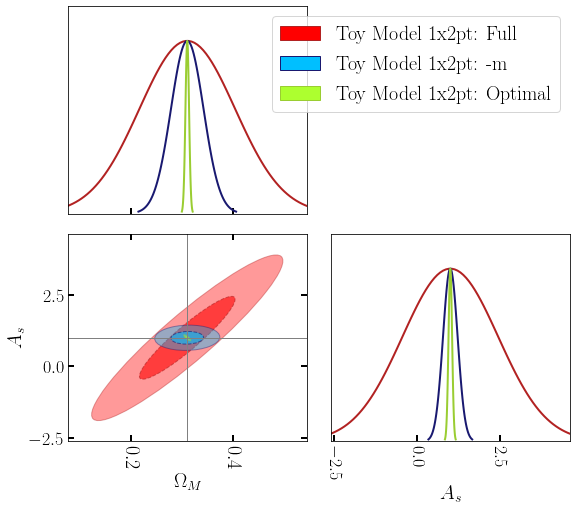

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & Toy Model 1x2pt: Full & $ \pm 0.094 $ & $ \pm 0.745 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 1x2pt: -m & $ \pm 0.032 $ & $ \pm 0.110 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 1x2pt: Optimal & $ \pm 0.004 $ & $ \pm 0.017 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


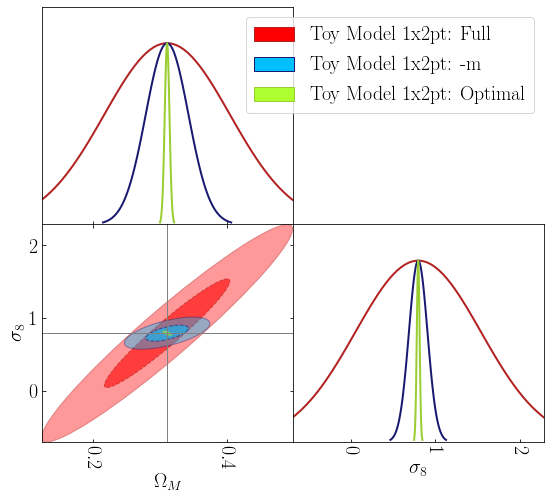

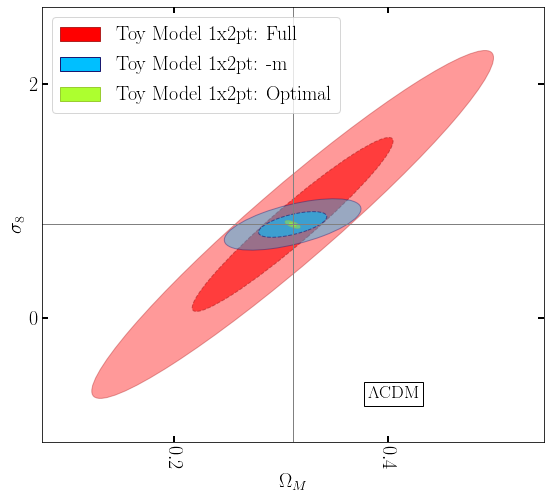




 Optimal 1x2pt // DES LCDM


Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & Toy Model 1x2pt: Optimal & $ \pm 0.004 $ & $ \pm 0.054 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


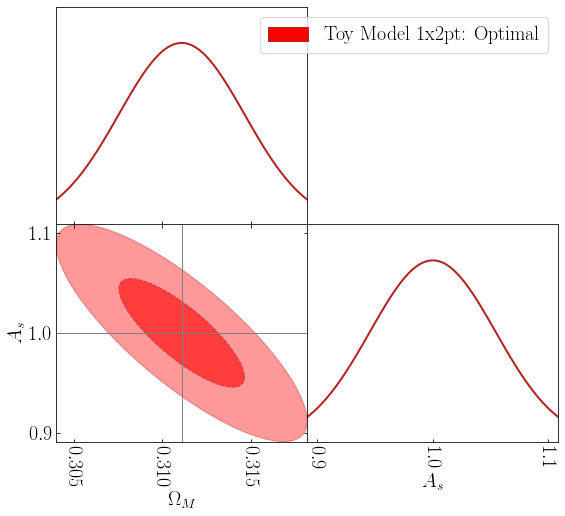

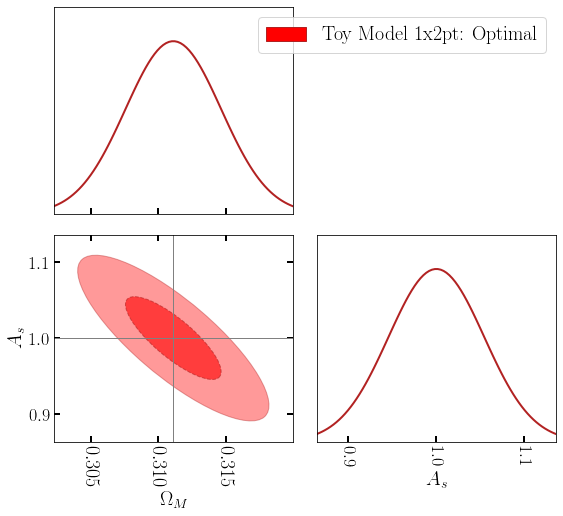

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & Toy Model 1x2pt: Optimal & $ \pm 0.004 $ & $ \pm 0.017 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


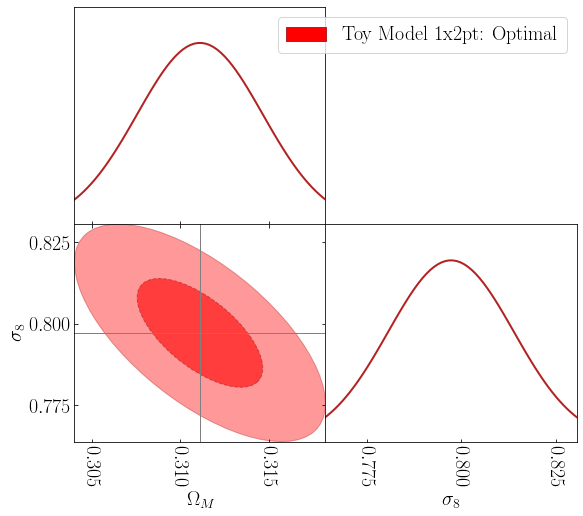

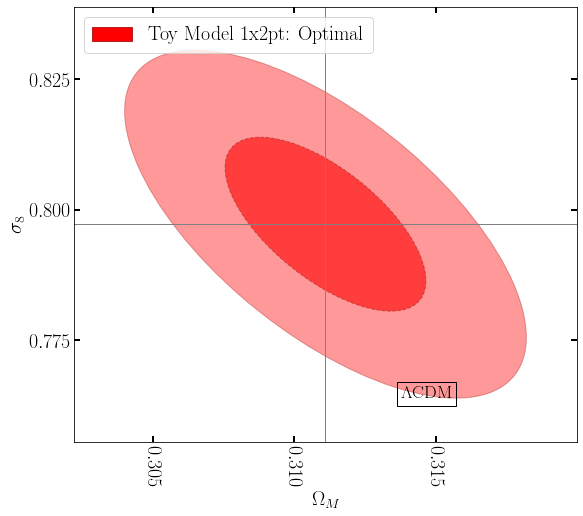

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & Toy Model 3x2pt: Photometric & $ \pm 0.005 $ & $ \pm 0.135 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 3x2pt: Spectroscopic & $ \pm 0.005 $ & $ \pm 0.101 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


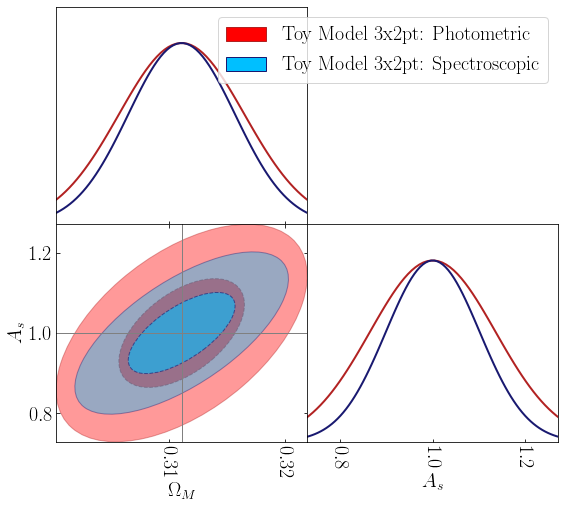

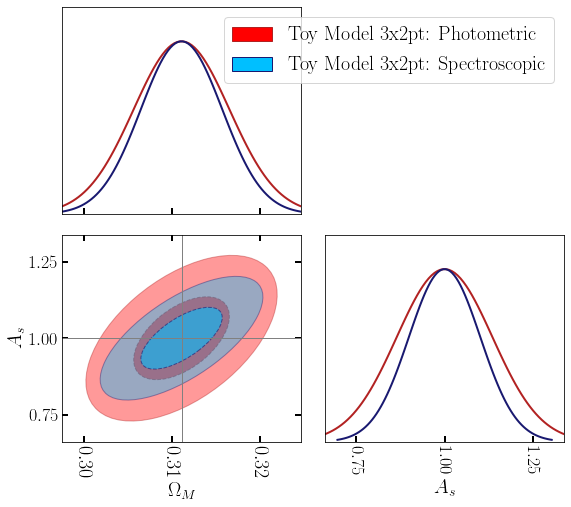

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & Toy Model 3x2pt: Photometric & $ \pm 0.005 $ & $ \pm 0.060 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & Toy Model 3x2pt: Spectroscopic & $ \pm 0.005 $ & $ \pm 0.047 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


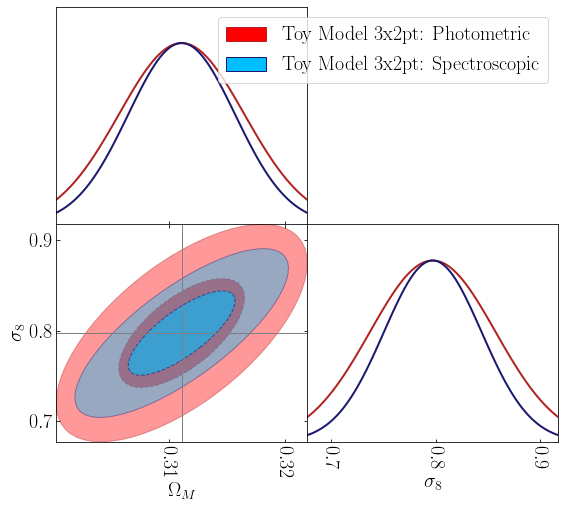

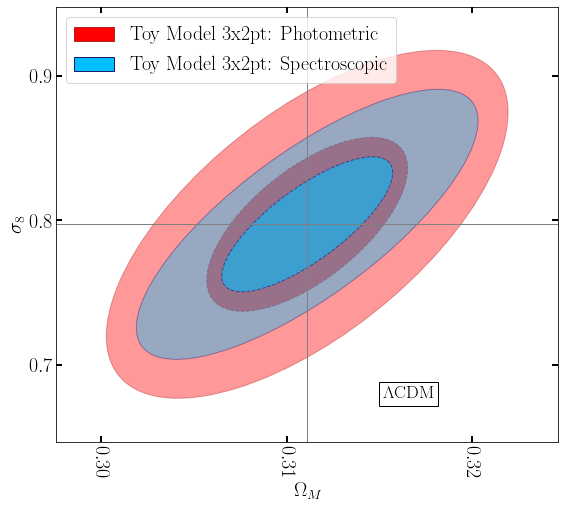




 ##################################### 






 DES 3x2pt vs. 4MOST+DES 3x2pt // DES wCDM


Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
wCDM & DES 3x2pt & $ \pm 0.010 $ & $ \pm 0.156 $ & $-$ & $-$ & $-$ & $ \pm 0.163 $ & $-$& $ $ & $ $ \\
\hline
wCDM & 4MOST+DES 3x2pt & $ \pm 0.012 $ & $ \pm 0.199 $ & $-$ & $-$ & $-$ & $ \pm 0.238 $ & $-$& $ $ & $ $ \\
\hline


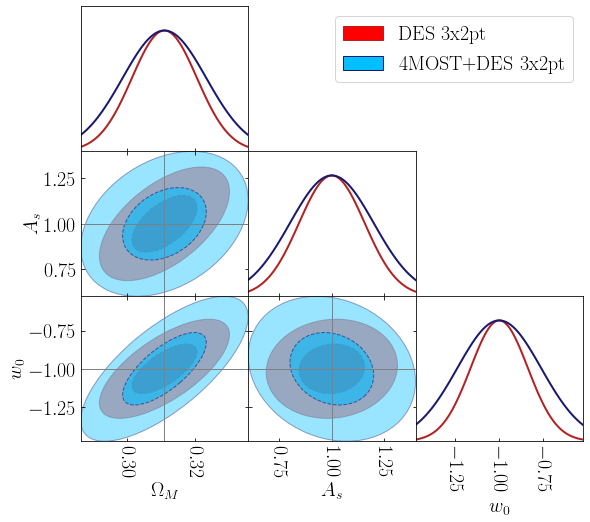

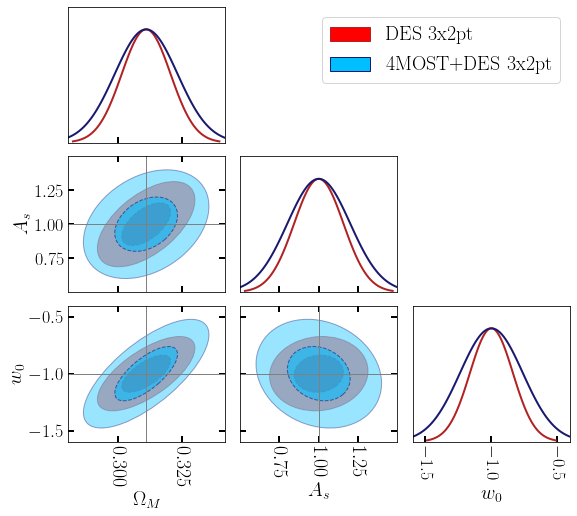

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
wCDM & DES 3x2pt & $ \pm 0.010 $ & $ \pm 0.074 $ & $-$ & $-$ & $-$ & $ \pm 0.163 $ & $-$& $ $ & $ $ \\
\hline
wCDM & 4MOST+DES 3x2pt & $ \pm 0.012 $ & $ \pm 0.100 $ & $-$ & $-$ & $-$ & $ \pm 0.238 $ & $-$& $ $ & $ $ \\
\hline


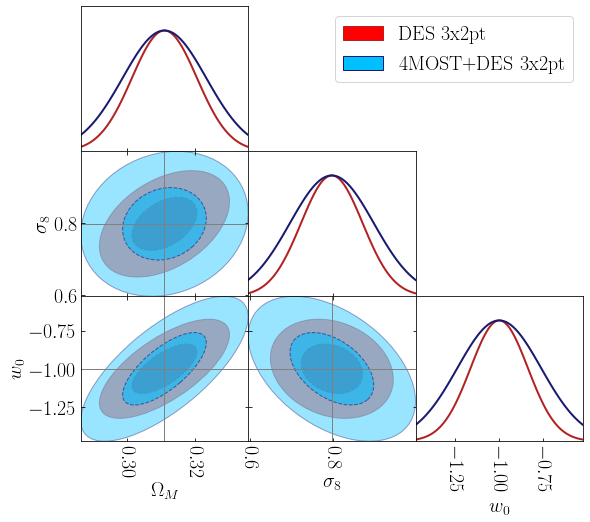

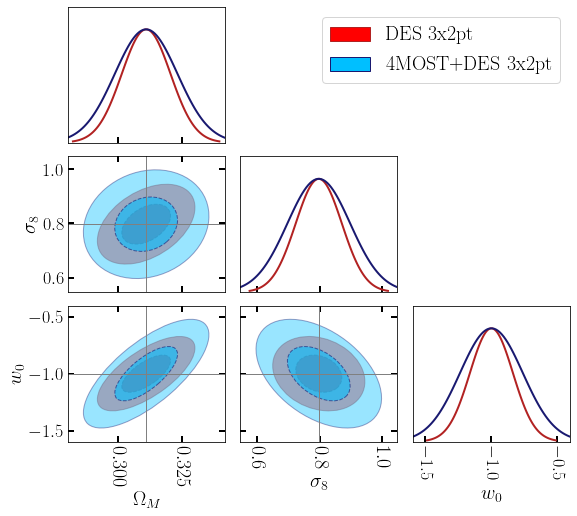




 DES 3x2pt vs. 4MOST+DES 3x2pt // DES LCDM


Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & DES 3x2pt & $ \pm 0.007 $ & $ \pm 0.156 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & 4MOST+DES 3x2pt & $ \pm 0.009 $ & $ \pm 0.196 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


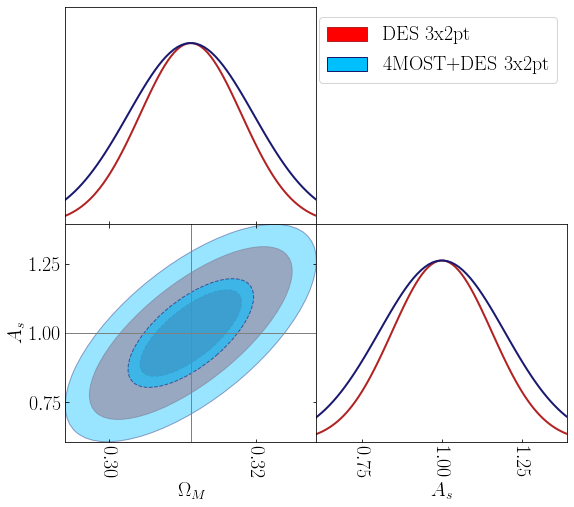

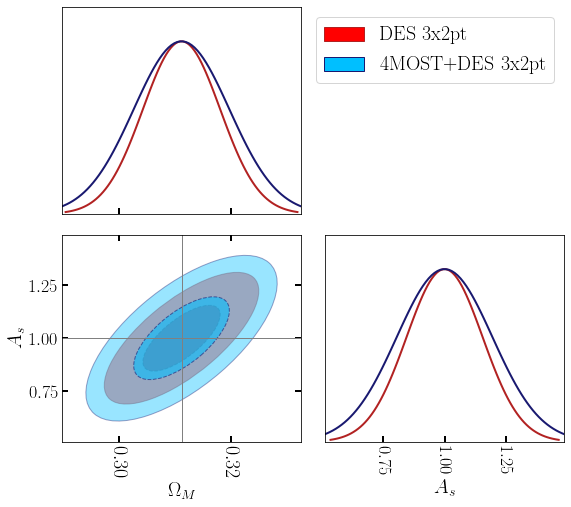

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & DES 3x2pt & $ \pm 0.007 $ & $ \pm 0.072 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline
LCDM & 4MOST+DES 3x2pt & $ \pm 0.009 $ & $ \pm 0.090 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


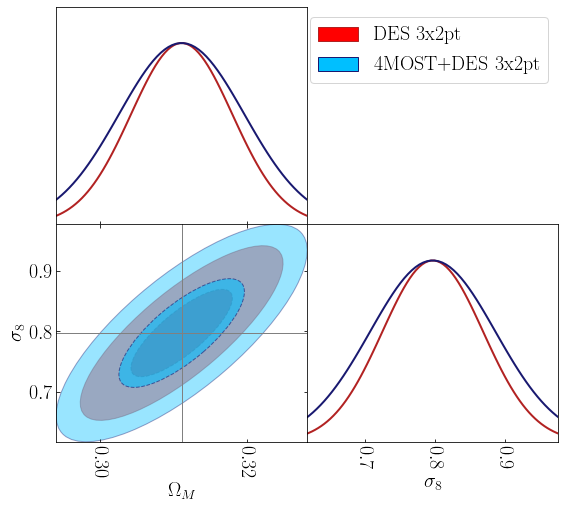

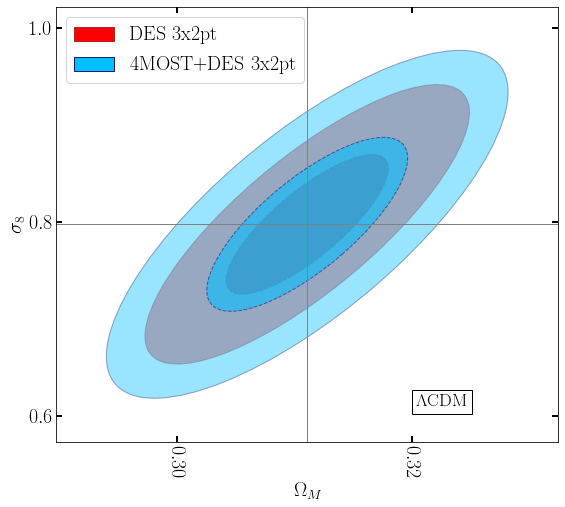




 WL 1x2pt // DES wCDM


Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
wCDM & DES 1x2pt: Weak Lensing & $ \pm 0.091 $ & $ \pm 0.436 $ & $-$ & $-$ & $-$ & $ \pm 1.195 $ & $-$& $ $ & $ $ \\
\hline


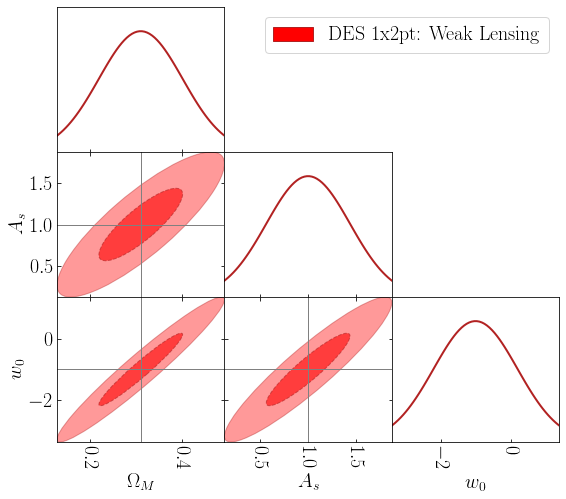

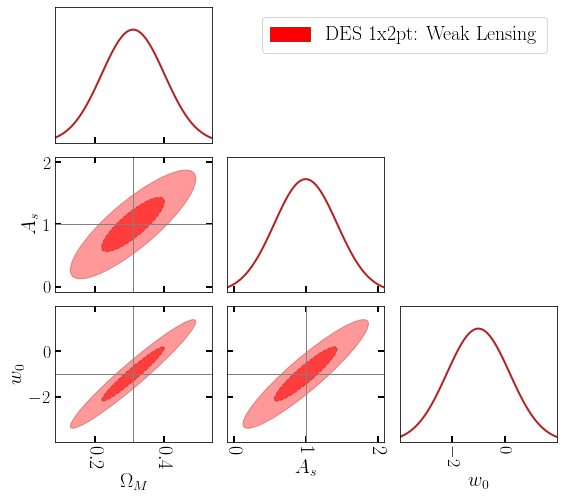

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
wCDM & DES 1x2pt: Weak Lensing & $ \pm 0.091 $ & $ \pm 0.436 $ & $-$ & $-$ & $-$ & $ \pm 1.195 $ & $-$& $ $ & $ $ \\
\hline


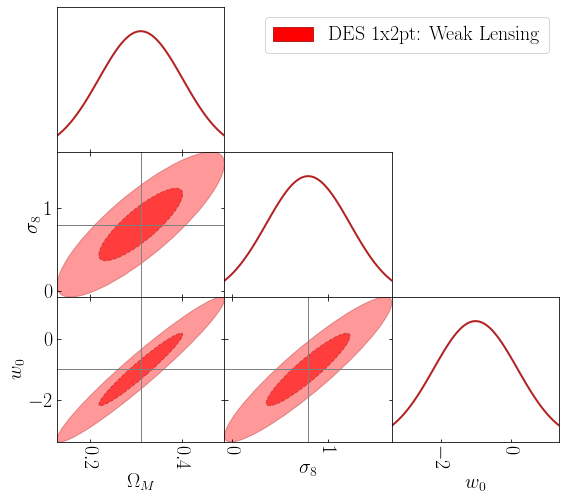

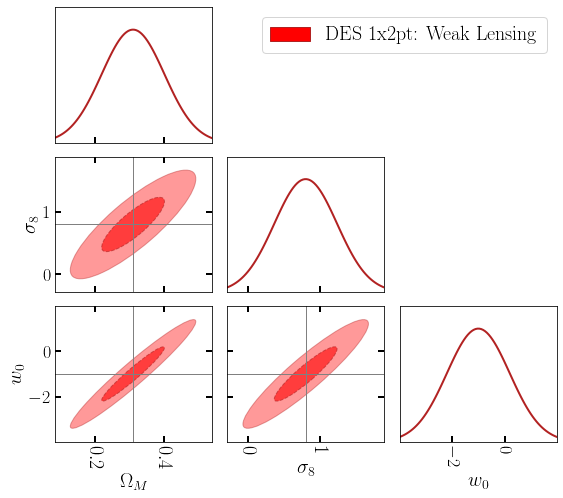




 WL 1x2pt // DES LCDM


[[2033.86964747  135.12940926]
 [ 135.12940926   44.13312728]]
Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & DES 1x2pt: Weak Lensing & $ \pm 0.025 $ & $ \pm 0.169 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


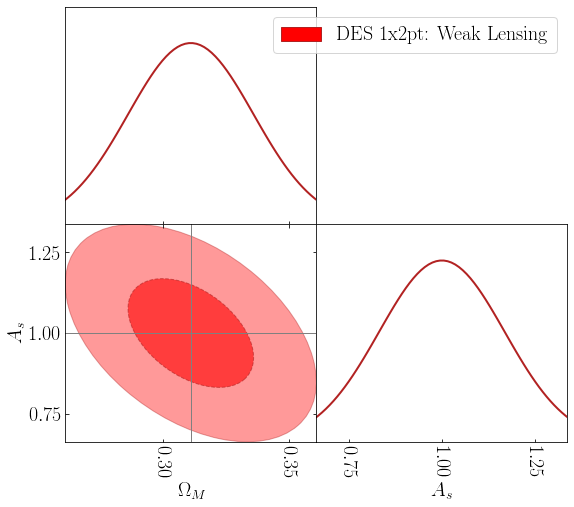

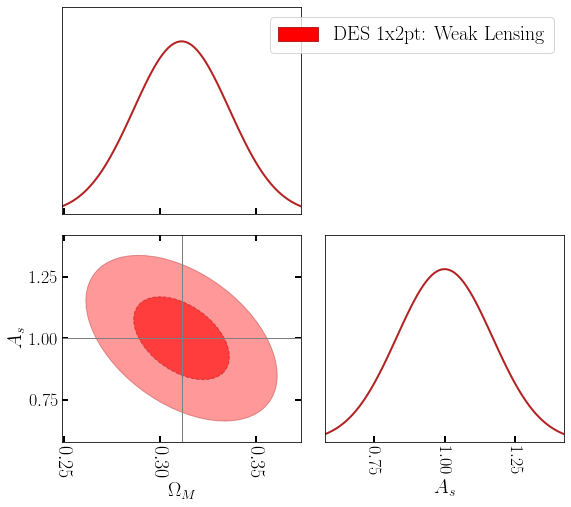

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
LCDM & DES 1x2pt: Weak Lensing & $ \pm 0.025 $ & $ \pm 0.062 $ & $-$ & $-$ & $-$ & $-$ & $-$& $ $ & $ $ \\
\hline


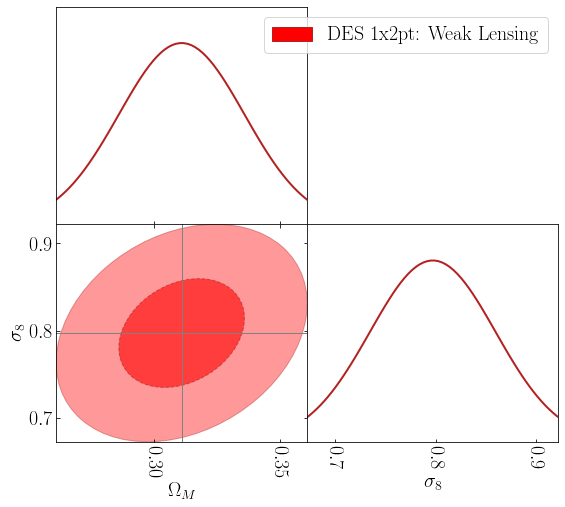

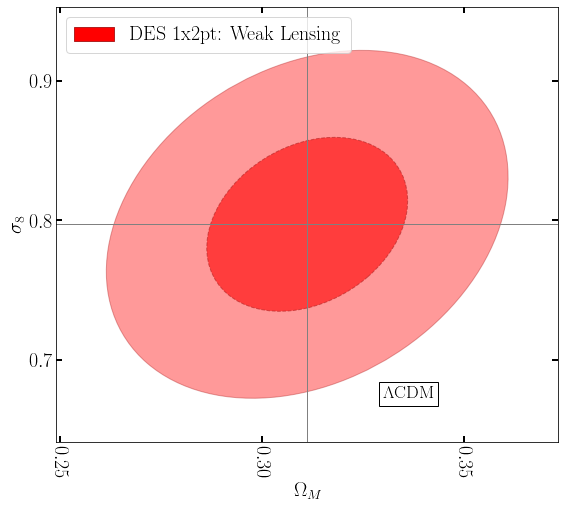




 Planck+DES vs. Planck+4MOST+DES // DESnuLCDM


Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
$\nu \Lambda$CDM & Planck + DES + DES & $ \pm 0.013 $ & $ \pm 0.003 $ & $ \pm 0.001 $ & $ \pm 0.003 $ & $ \pm 0.011 $ & $-$ & $ \pm 0.114 $& $ $ & $ $ \\
\hline
$\nu \Lambda$CDM & Planck + 4MOST + DES & $ \pm 0.016 $ & $ \pm 0.003 $ & $ \pm 0.002 $ & $ \pm 0.003 $ & $ \pm 0.013 $ & $-$ & $ \pm 0.145 $& $ $ & $ $ \\
\hline


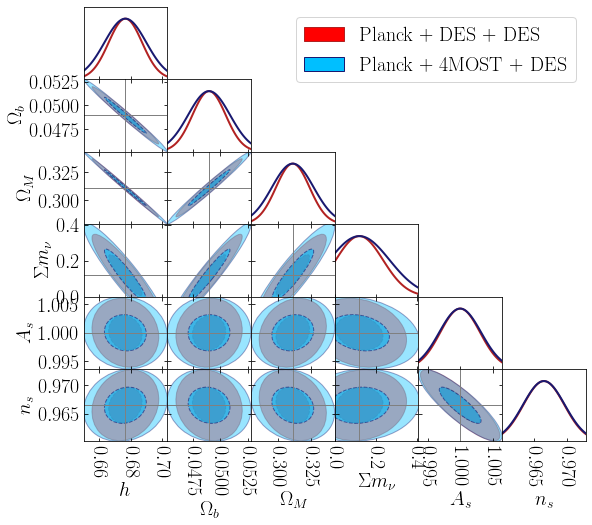

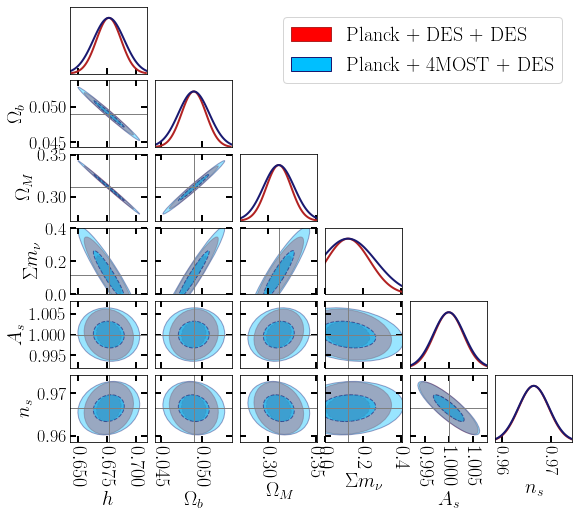

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
$\nu \Lambda$CDM & Planck + DES + DES & $ \pm 0.013 $ & $ \pm 0.026 $ & $ \pm 0.001 $ & $ \pm 0.003 $ & $ \pm 0.011 $ & $-$ & $ \pm 0.114 $& $ $ & $ $ \\
\hline
$\nu \Lambda$CDM & Planck + 4MOST + DES & $ \pm 0.016 $ & $ \pm 0.033 $ & $ \pm 0.002 $ & $ \pm 0.003 $ & $ \pm 0.013 $ & $-$ & $ \pm 0.145 $& $ $ & $ $ \\
\hline


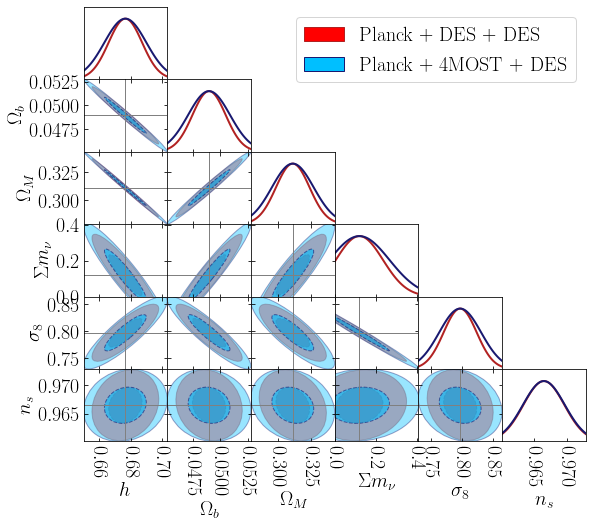

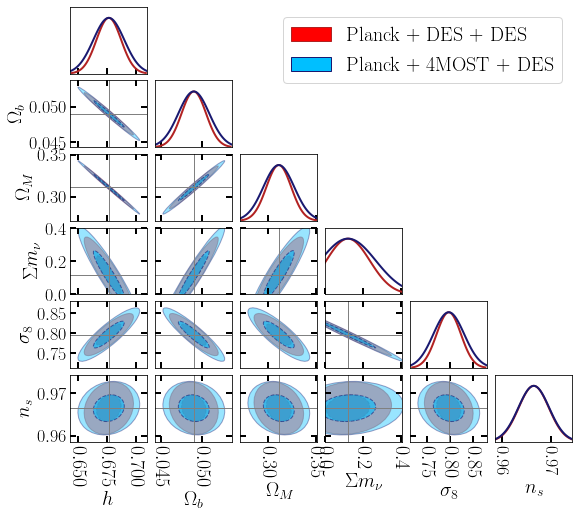




 Planck+DES vs. Planck+4MOST+DES // DESnuwCDM


Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
$\nu$wCDM & Planck + DES + DES & $ \pm 0.015 $ & $ \pm 0.003 $ & $ \pm 0.002 $ & $ \pm 0.003 $ & $ \pm 0.015 $ & $ \pm 0.069 $ & $ \pm 0.141 $& $ $ & $ $ \\
\hline
$\nu$wCDM & Planck + 4MOST + DES & $ \pm 0.017 $ & $ \pm 0.003 $ & $ \pm 0.002 $ & $ \pm 0.003 $ & $ \pm 0.017 $ & $ \pm 0.075 $ & $ \pm 0.182 $& $ $ & $ $ \\
\hline


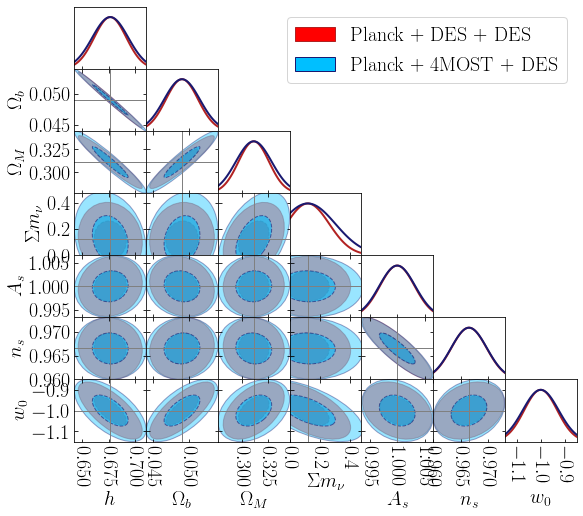

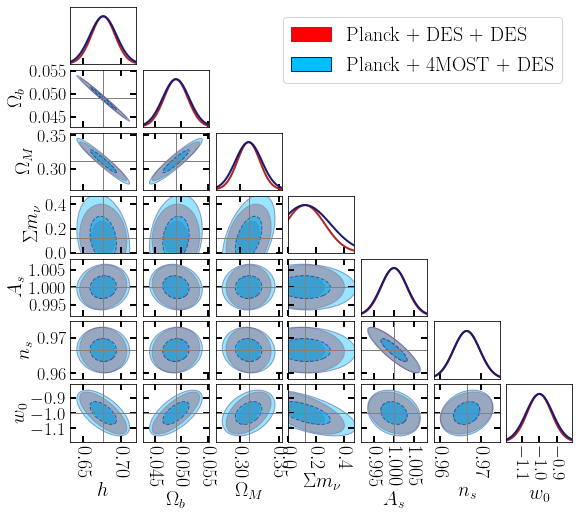

Model & Data sets & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(\Omega_b)$ & $\sigma(n_s)$ & $\sigma(h)$ & $\sigma(w_0)$ & $\sigma(M_\nu)$ & FoM$_{\sigma_8,\Omega_M}$ & FoM$_{w_0,\Omega_M}$ \\
\hline \hline
$\nu$wCDM & Planck + DES + DES & $ \pm 0.015 $ & $ \pm 0.027 $ & $ \pm 0.002 $ & $ \pm 0.003 $ & $ \pm 0.015 $ & $ \pm 0.069 $ & $ \pm 0.141 $& $ $ & $ $ \\
\hline
$\nu$wCDM & Planck + 4MOST + DES & $ \pm 0.017 $ & $ \pm 0.034 $ & $ \pm 0.002 $ & $ \pm 0.003 $ & $ \pm 0.017 $ & $ \pm 0.075 $ & $ \pm 0.182 $& $ $ & $ $ \\
\hline


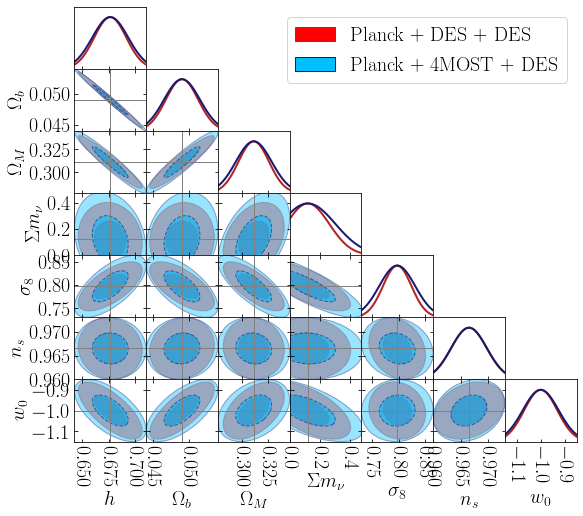

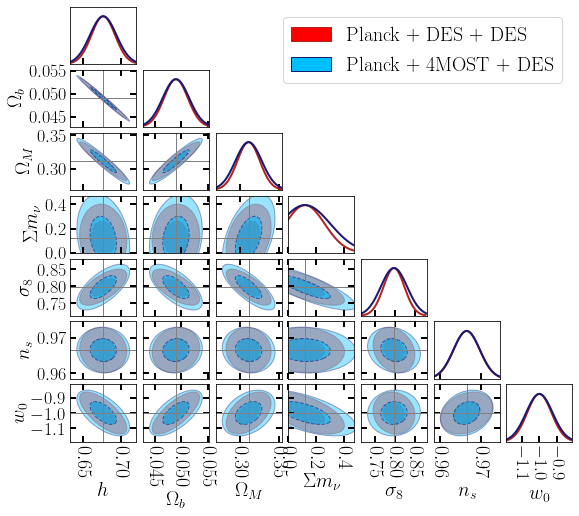




 Planck // nuwCDM


Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\nu$wCDM & TTTEEE & $ 0.008733 $ & $ 0.0002284 $ & $ 0.2428 $ & $ 0.009358 $ & $ 0.008217 $ & $ 0.003576 $ & $ 0.9259 $ & $ 0.1939 $ & $ 0.2016 $ & $ 3.062 $ \\
\hline


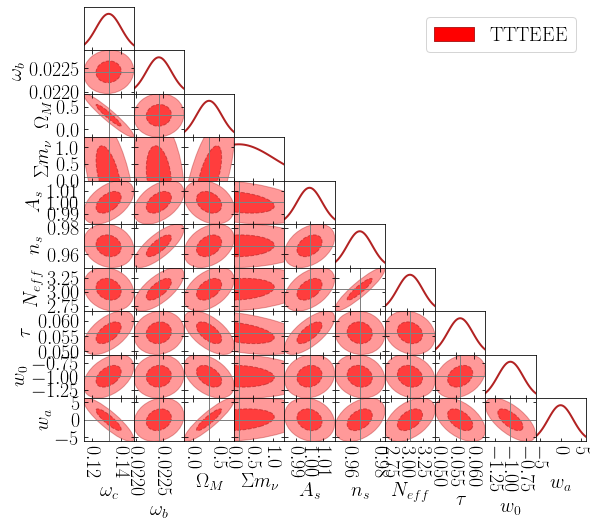

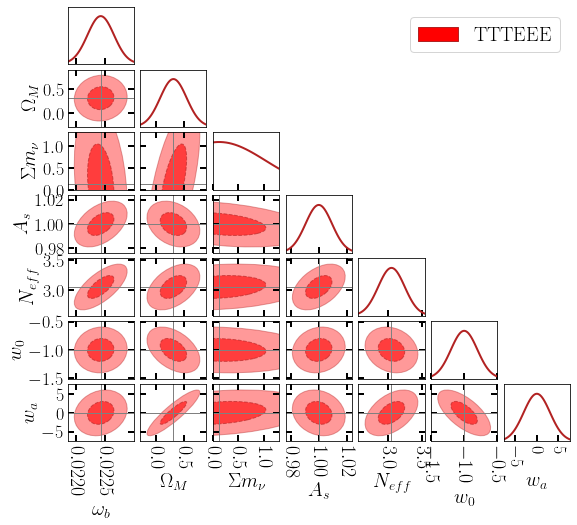

Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\nu$wCDM & TTTEEE & $ 0.008733 $ & $ 0.0002284 $ & $ 0.2428 $ & $ 0.3425 $ & $ 0.008217 $ & $ 0.003576 $ & $ 0.9259 $ & $ 0.1939 $ & $ 0.2016 $ & $ 3.062 $ \\
\hline


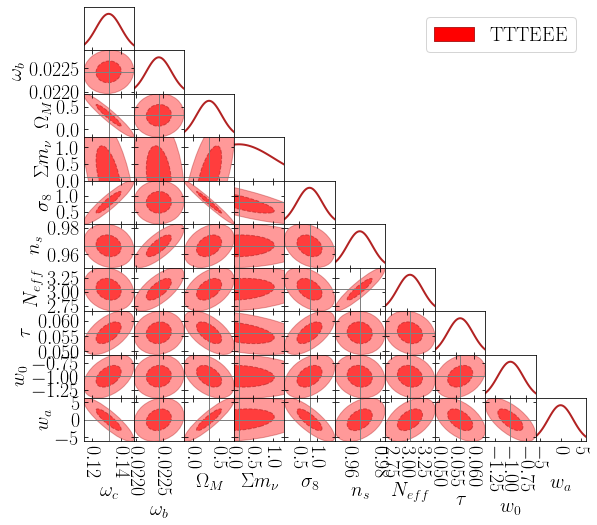

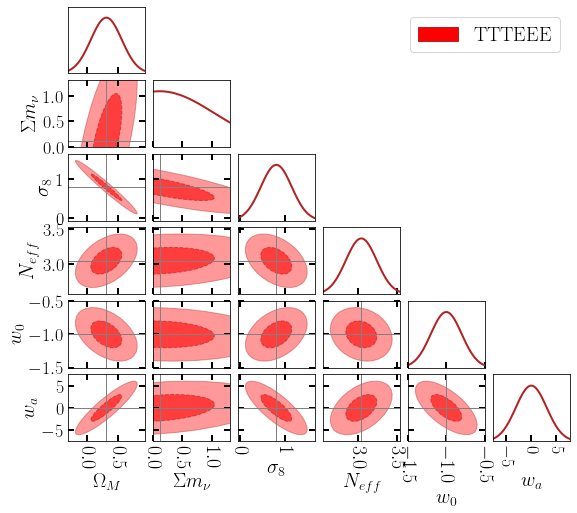




 Plank+DES vs. Planck+4MOST vs. Planck+4MOST+DES // nuwCDM


Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\nu$wCDM & TTTEEE+CS+GGL & $ 0.0033 $ & $ 0.0002177 $ & $ 0.05238 $ & $ 0.008711 $ & $ 0.007478 $ & $ 0.002943 $ & $ 0.4753 $ & $ 0.1692 $ & $ 0.1717 $ & $ 0.8424 $ \\
\hline
$\nu$wCDM & TTTEEE+ISW+GC & $ 0.003298 $ & $ 0.0002098 $ & $ 0.04792 $ & $ 0.008684 $ & $ 0.007363 $ & $ 0.002906 $ & $ 0.4023 $ & $ 0.1676 $ & $ 0.1683 $ & $ 0.6289 $ \\
\hline
$\nu$wCDM & TTTEEE+ISW+GC+CS+GGL & $ 0.002809 $ & $ 0.0002094 $ & $ 0.02713 $ & $ 0.008519 $ & $ 0.007344 $ & $ 0.002889 $ & $ 0.3116 $ & $ 0.1672 $ & $ 0.1663 $ & $ 0.5897 $ \\
\hline


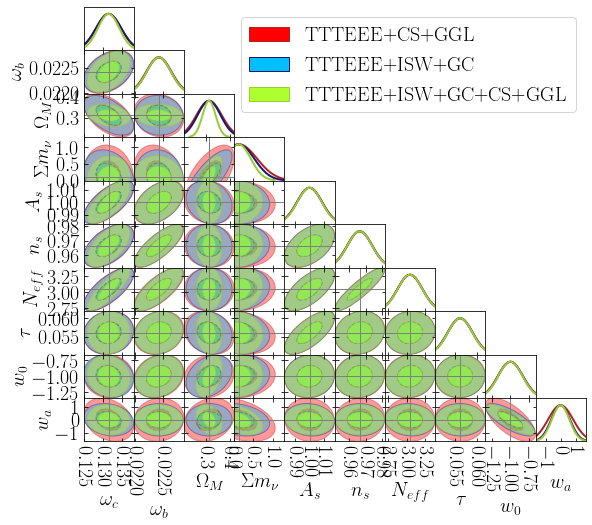

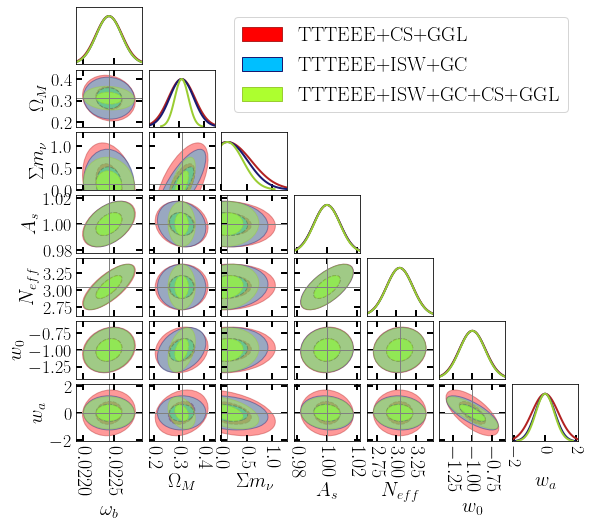

Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\nu$wCDM & TTTEEE+CS+GGL & $ 0.0033 $ & $ 0.0002177 $ & $ 0.05238 $ & $ 0.09472 $ & $ 0.007478 $ & $ 0.002943 $ & $ 0.4753 $ & $ 0.1692 $ & $ 0.1717 $ & $ 0.8424 $ \\
\hline
$\nu$wCDM & TTTEEE+ISW+GC & $ 0.003298 $ & $ 0.0002098 $ & $ 0.04792 $ & $ 0.09001 $ & $ 0.007363 $ & $ 0.002906 $ & $ 0.4023 $ & $ 0.1676 $ & $ 0.1683 $ & $ 0.6289 $ \\
\hline
$\nu$wCDM & TTTEEE+ISW+GC+CS+GGL & $ 0.002809 $ & $ 0.0002094 $ & $ 0.02713 $ & $ 0.05509 $ & $ 0.007344 $ & $ 0.002889 $ & $ 0.3116 $ & $ 0.1672 $ & $ 0.1663 $ & $ 0.5897 $ \\
\hline


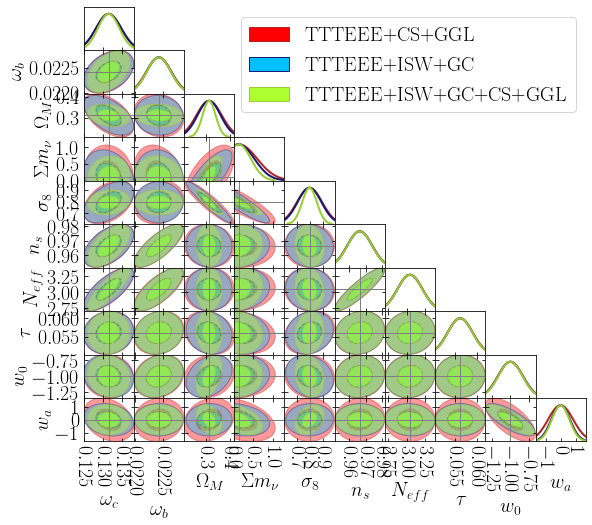

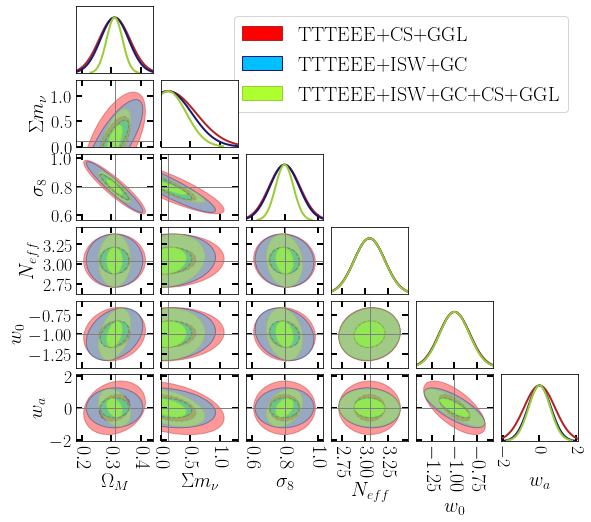




 Planck+4MOST (Con) vs. Planck+4MOST (Int) // nuwCDM


Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\nu$wCDM & TTTEEE+ISW+GC & $ 0.003298 $ & $ 0.0002098 $ & $ 0.04792 $ & $ 0.008684 $ & $ 0.007363 $ & $ 0.002906 $ & $ 0.4023 $ & $ 0.1676 $ & $ 0.1683 $ & $ 0.6289 $ \\
\hline
$\nu$wCDM & TTTEEE+ISW+GC No number density & $ 0.00328 $ & $ 0.0002097 $ & $ 0.04763 $ & $ 0.008667 $ & $ 0.007359 $ & $ 0.002906 $ & $ 0.3991 $ & $ 0.1674 $ & $ 0.1682 $ & $ 0.6257 $ \\
\hline


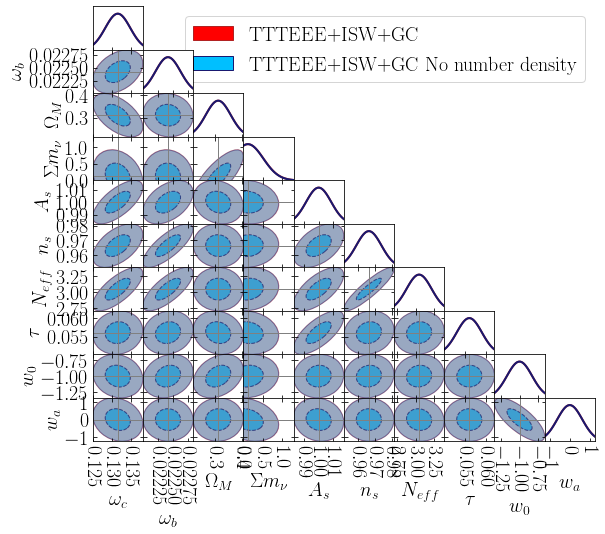

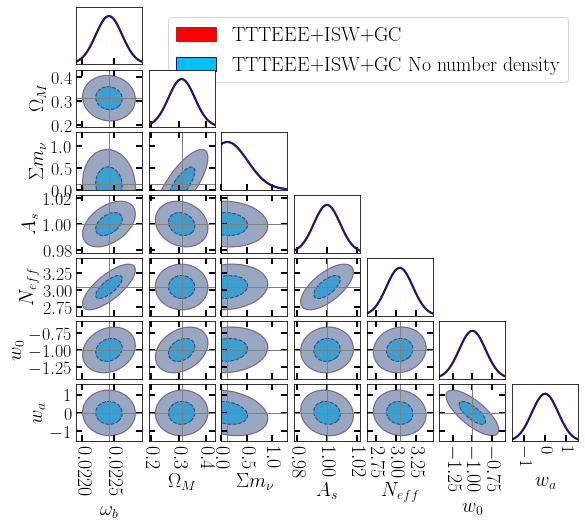

Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\nu$wCDM & TTTEEE+ISW+GC & $ 0.003298 $ & $ 0.0002098 $ & $ 0.04792 $ & $ 0.09001 $ & $ 0.007363 $ & $ 0.002906 $ & $ 0.4023 $ & $ 0.1676 $ & $ 0.1683 $ & $ 0.6289 $ \\
\hline
$\nu$wCDM & TTTEEE+ISW+GC No number density & $ 0.00328 $ & $ 0.0002097 $ & $ 0.04763 $ & $ 0.08927 $ & $ 0.007359 $ & $ 0.002906 $ & $ 0.3991 $ & $ 0.1674 $ & $ 0.1682 $ & $ 0.6257 $ \\
\hline


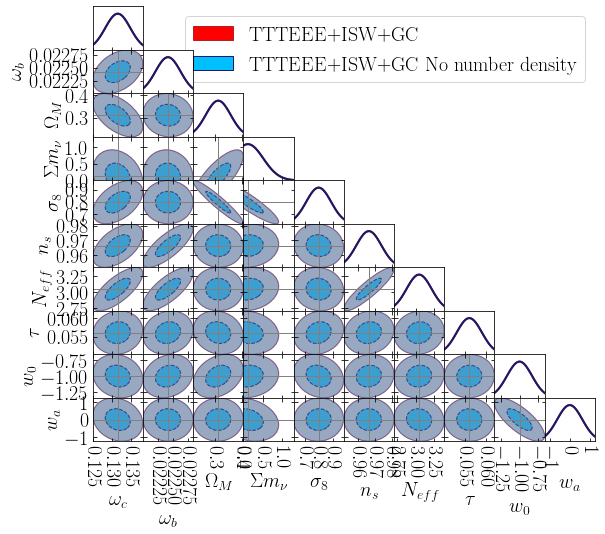

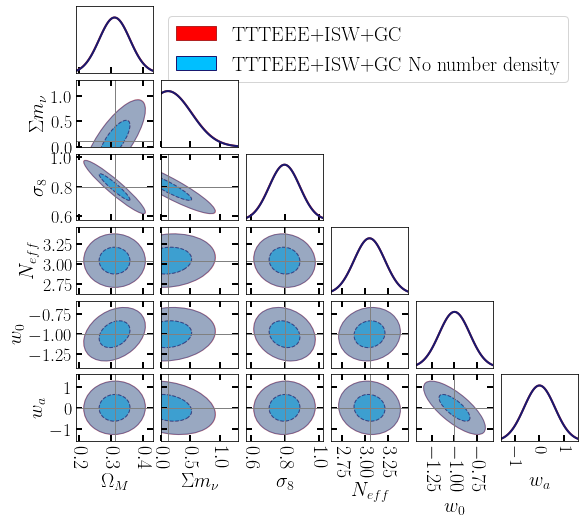




 Planck // LCDM


Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\Lambda$CDM & TTTEEE & $ 0.001062 $ & $ 0.0001349 $ & $ 0.007893 $ & $ 0.006311 $ & $ 0.003332 $ & $ 0.002868 $ & $-$ & $-$ & $-$ & $-$ \\
\hline


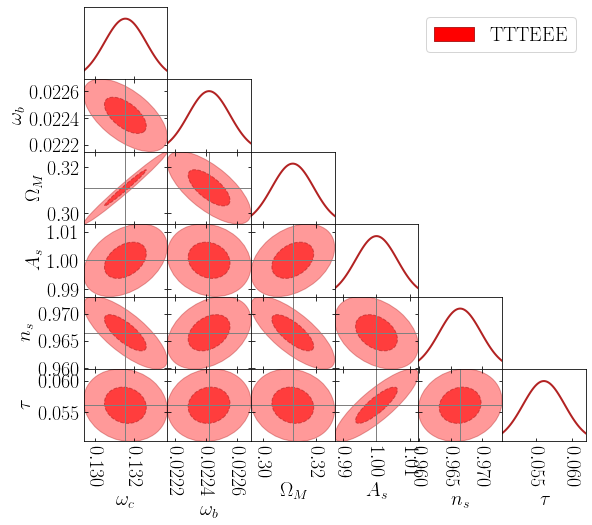

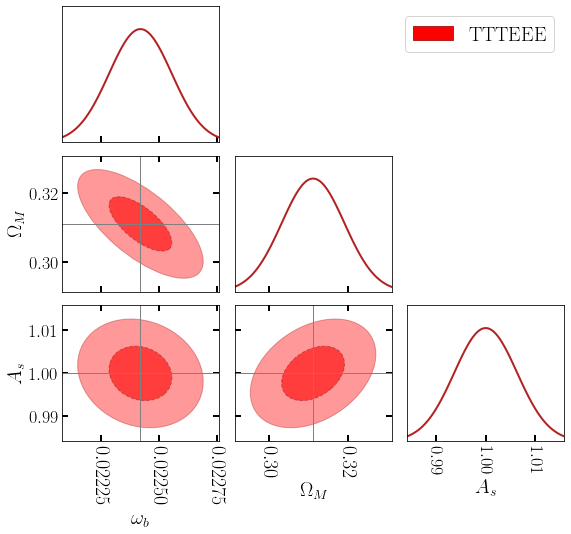

Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\Lambda$CDM & TTTEEE & $ 0.001062 $ & $ 0.0001349 $ & $ 0.007893 $ & $ 0.005139 $ & $ 0.003332 $ & $ 0.002868 $ & $-$ & $-$ & $-$ & $-$ \\
\hline


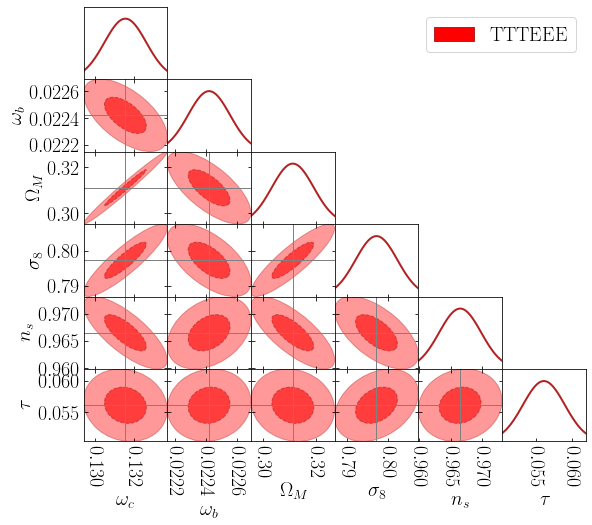

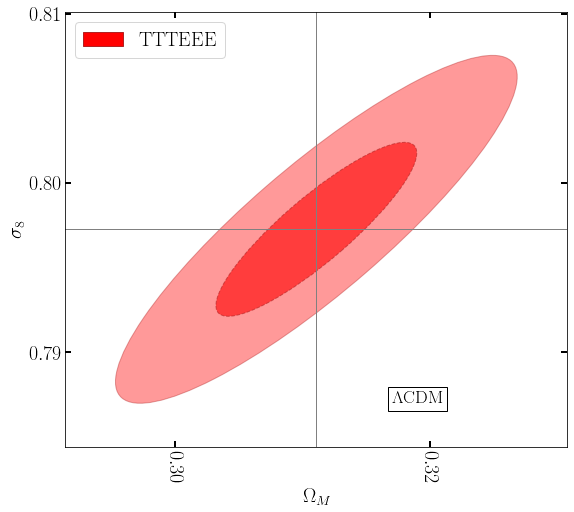




 Planck vs. Plank+DES vs. Planck+4MOST vs. Planck+4MOST+DES // LCDM


Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\Lambda$CDM & TTTEEE & $ 0.001062 $ & $ 0.0001349 $ & $ 0.007893 $ & $ 0.006311 $ & $ 0.003332 $ & $ 0.002868 $ & $-$ & $-$ & $-$ & $-$ \\
\hline
$\Lambda$CDM & TTTEEE+CS+GGL & $ 0.001012 $ & $ 0.000131 $ & $ 0.007509 $ & $ 0.006288 $ & $ 0.003282 $ & $ 0.002864 $ & $-$ & $-$ & $-$ & $-$ \\
\hline
$\Lambda$CDM & TTTEEE+ISW+GC & $ 0.0009805 $ & $ 0.0001287 $ & $ 0.007265 $ & $ 0.006262 $ & $ 0.003243 $ & $ 0.002862 $ & $-$ & $-$ & $-$ & $-$ \\
\hline
$\Lambda$CDM & TTTEEE+ISW+GC+CS+GGL & $ 0.0009476 $ & $ 0.0001264 $ & $ 0.007011 $ & $ 0.006248 $ & $ 0.0032 $ & $ 0.002857 $ & $-$ & $-$ & $-$ & $-$ \\
\hline


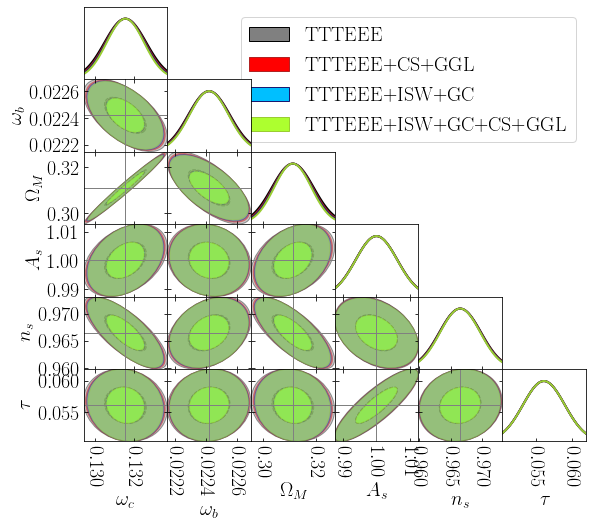

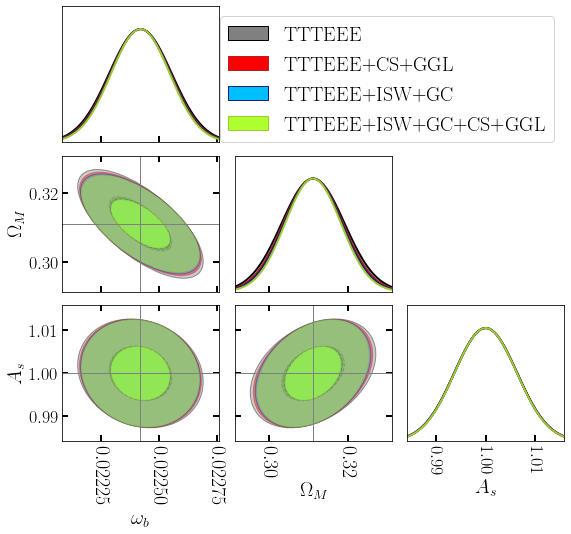

Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\Lambda$CDM & TTTEEE & $ 0.001062 $ & $ 0.0001349 $ & $ 0.007893 $ & $ 0.005139 $ & $ 0.003332 $ & $ 0.002868 $ & $-$ & $-$ & $-$ & $-$ \\
\hline
$\Lambda$CDM & TTTEEE+CS+GGL & $ 0.001012 $ & $ 0.000131 $ & $ 0.007509 $ & $ 0.004946 $ & $ 0.003282 $ & $ 0.002864 $ & $-$ & $-$ & $-$ & $-$ \\
\hline
$\Lambda$CDM & TTTEEE+ISW+GC & $ 0.0009805 $ & $ 0.0001287 $ & $ 0.007265 $ & $ 0.004815 $ & $ 0.003243 $ & $ 0.002862 $ & $-$ & $-$ & $-$ & $-$ \\
\hline
$\Lambda$CDM & TTTEEE+ISW+GC+CS+GGL & $ 0.0009476 $ & $ 0.0001264 $ & $ 0.007011 $ & $ 0.004696 $ & $ 0.0032 $ & $ 0.002857 $ & $-$ & $-$ & $-$ & $-$ \\
\hline


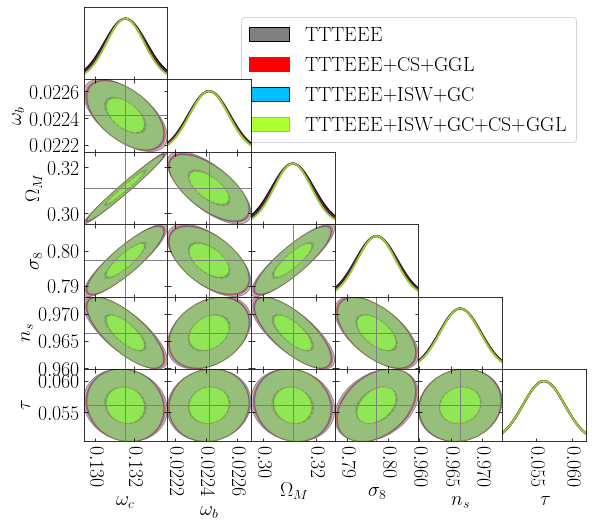

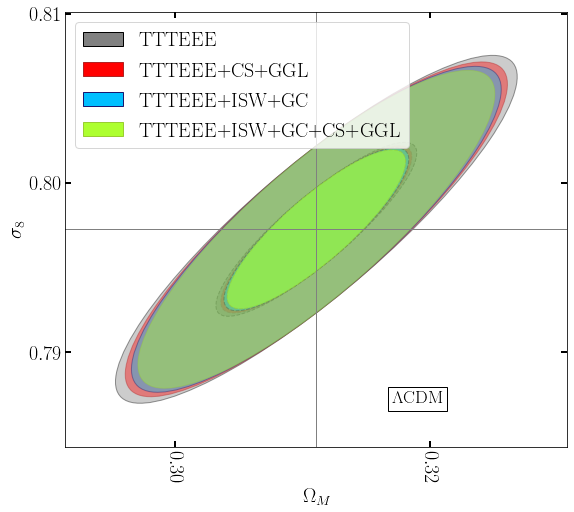




 Planck+4MOST (Con) vs. Planck+4MOST (Int) // LCDM


Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\Lambda$CDM & TTTEEE+ISW+GC & $ 0.0009805 $ & $ 0.0001287 $ & $ 0.007265 $ & $ 0.006262 $ & $ 0.003243 $ & $ 0.002862 $ & $-$ & $-$ & $-$ & $-$ \\
\hline
$\Lambda$CDM & TTTEEE+ISW+GC No number density & $ 0.0009758 $ & $ 0.0001283 $ & $ 0.007229 $ & $ 0.00626 $ & $ 0.003239 $ & $ 0.002861 $ & $-$ & $-$ & $-$ & $-$ \\
\hline


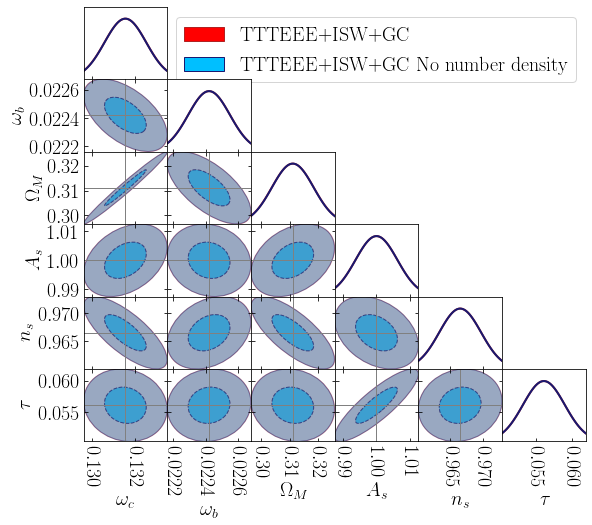

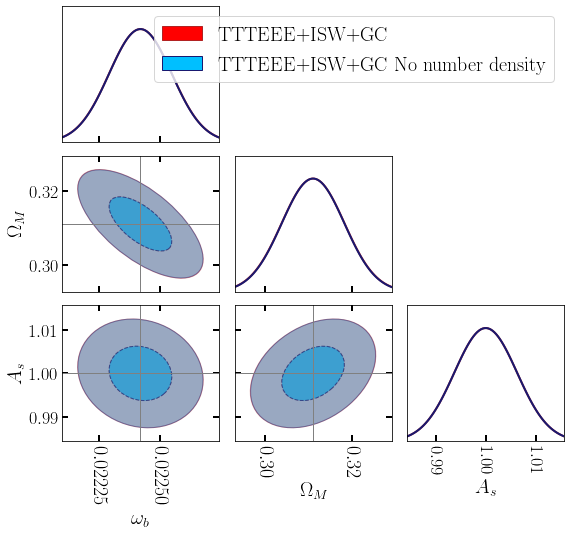

Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\Lambda$CDM & TTTEEE+ISW+GC & $ 0.0009805 $ & $ 0.0001287 $ & $ 0.007265 $ & $ 0.004815 $ & $ 0.003243 $ & $ 0.002862 $ & $-$ & $-$ & $-$ & $-$ \\
\hline
$\Lambda$CDM & TTTEEE+ISW+GC No number density & $ 0.0009758 $ & $ 0.0001283 $ & $ 0.007229 $ & $ 0.004796 $ & $ 0.003239 $ & $ 0.002861 $ & $-$ & $-$ & $-$ & $-$ \\
\hline


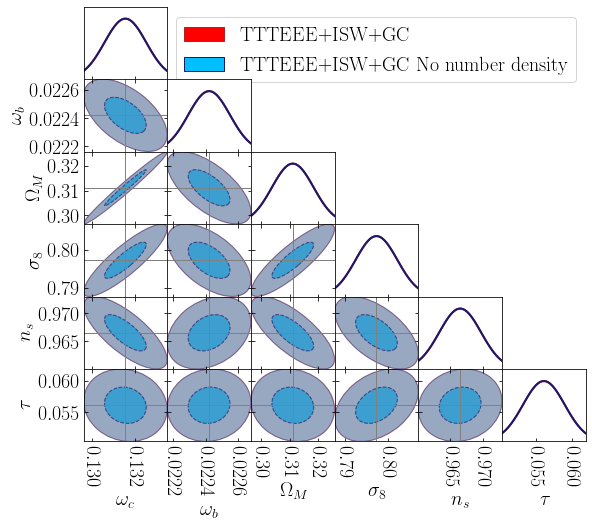

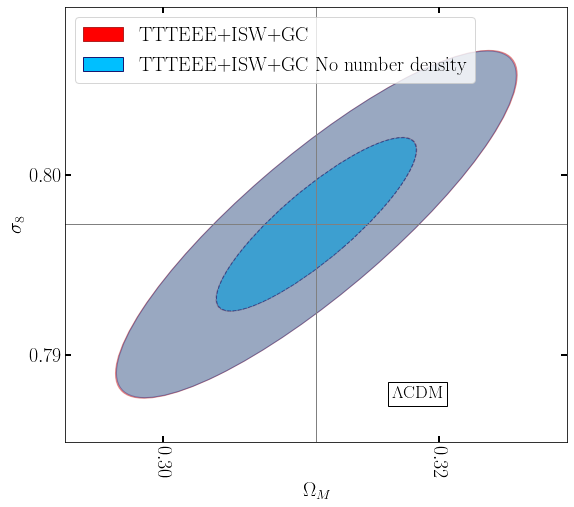




 Planck vs. Plank+DES vs. Planck+4MOST vs. Planck+4MOST+DES // wCDM


Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
wCDM & TTTEEE & $ 0.007313 $ & $ 0.00014 $ & $ 0.1703 $ & $ 0.007201 $ & $ 0.00334 $ & $ 0.003189 $ & $-$ & $-$ & $ 0.1972 $ & $ 2.661 $ \\
\hline
wCDM & TTTEEE+CS+GGL & $ 0.002266 $ & $ 0.0001366 $ & $ 0.0415 $ & $ 0.006412 $ & $ 0.003313 $ & $ 0.00288 $ & $-$ & $-$ & $ 0.1708 $ & $ 0.7781 $ \\
\hline
wCDM & TTTEEE+ISW+GC & $ 0.002001 $ & $ 0.0001371 $ & $ 0.03085 $ & $ 0.006383 $ & $ 0.003313 $ & $ 0.002865 $ & $-$ & $-$ & $ 0.1668 $ & $ 0.6091 $ \\
\hline
wCDM & TTTEEE+ISW+GC+CS+GGL & $ 0.001542 $ & $ 0.000133 $ & $ 0.02049 $ & $ 0.006331 $ & $ 0.003272 $ & $ 0.00286 $ & $-$ & $-$ & $ 0.1655 $ & $ 0.5314 $ \\
\hline


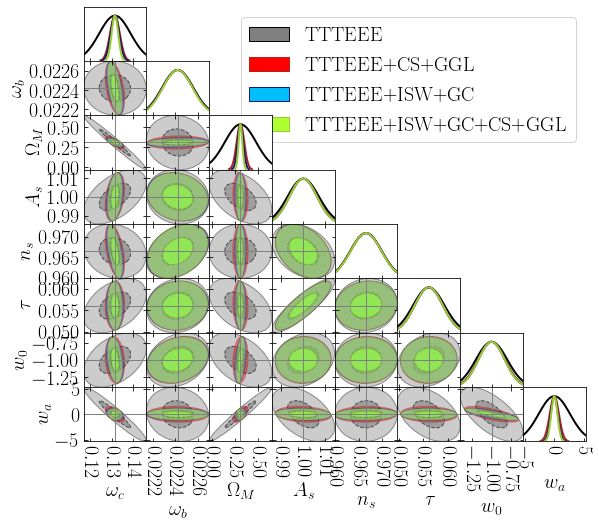

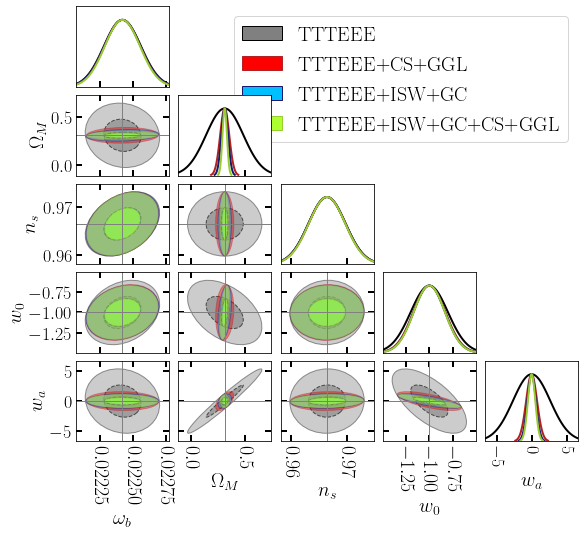

Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
wCDM & TTTEEE & $ 0.007313 $ & $ 0.00014 $ & $ 0.1703 $ & $ 0.1937 $ & $ 0.00334 $ & $ 0.003189 $ & $-$ & $-$ & $ 0.1972 $ & $ 2.661 $ \\
\hline
wCDM & TTTEEE+CS+GGL & $ 0.002266 $ & $ 0.0001366 $ & $ 0.0415 $ & $ 0.04861 $ & $ 0.003313 $ & $ 0.00288 $ & $-$ & $-$ & $ 0.1708 $ & $ 0.7781 $ \\
\hline
wCDM & TTTEEE+ISW+GC & $ 0.002001 $ & $ 0.0001371 $ & $ 0.03085 $ & $ 0.03743 $ & $ 0.003313 $ & $ 0.002865 $ & $-$ & $-$ & $ 0.1668 $ & $ 0.6091 $ \\
\hline
wCDM & TTTEEE+ISW+GC+CS+GGL & $ 0.001542 $ & $ 0.000133 $ & $ 0.02049 $ & $ 0.02439 $ & $ 0.003272 $ & $ 0.00286 $ & $-$ & $-$ & $ 0.1655 $ & $ 0.5314 $ \\
\hline


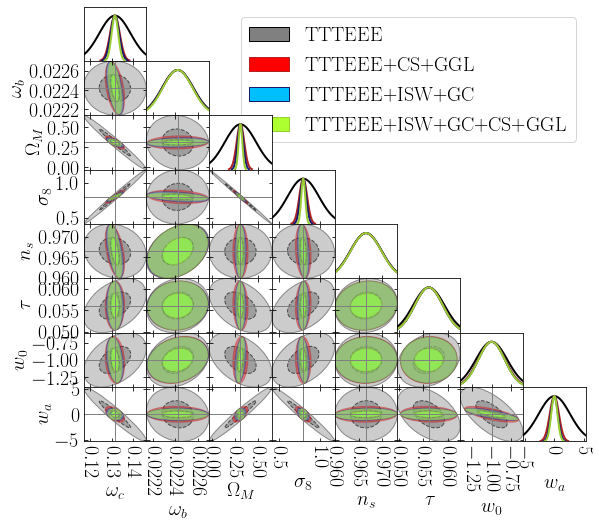

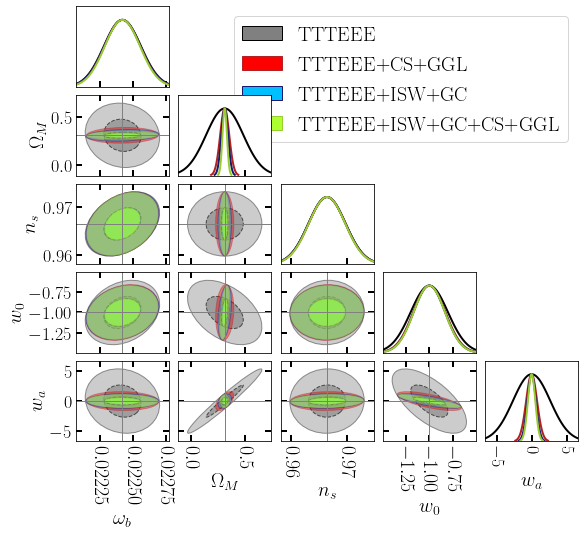




 Planck vs. Plank+DES vs. Planck+4MOST vs. Planck+4MOST+DES // nuLCDM


Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(A_s)/A_s$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\nu \Lambda$CDM & TTTEEE & $ 0.003934 $ & $ 0.000218 $ & $ 0.09731 $ & $ 0.009198 $ & $ 0.007414 $ & $ 0.0031 $ & $ 0.8916 $ & $ 0.1695 $ & $-$ & $-$ \\
\hline
$\nu \Lambda$CDM & TTTEEE+CS+GGL & $ 0.002969 $ & $ 0.0002059 $ & $ 0.04706 $ & $ 0.008688 $ & $ 0.007359 $ & $ 0.002939 $ & $ 0.4235 $ & $ 0.1684 $ & $-$ & $-$ \\
\hline
$\nu \Lambda$CDM & TTTEEE+ISW+GC & $ 0.00295 $ & $ 0.0002017 $ & $ 0.04173 $ & $ 0.008619 $ & $ 0.00731 $ & $ 0.002905 $ & $ 0.3876 $ & $ 0.167 $ & $-$ & $-$ \\
\hline
$\nu \Lambda$CDM & TTTEEE+ISW+GC+CS+GGL & $ 0.002699 $ & $ 0.0001979 $ & $ 0.02497 $ & $ 0.00849 $ & $ 0.007256 $ & $ 0.00288 $ & $ 0.2321 $ & $ 0.1665 $ & $-$ & $-$ \\
\hline


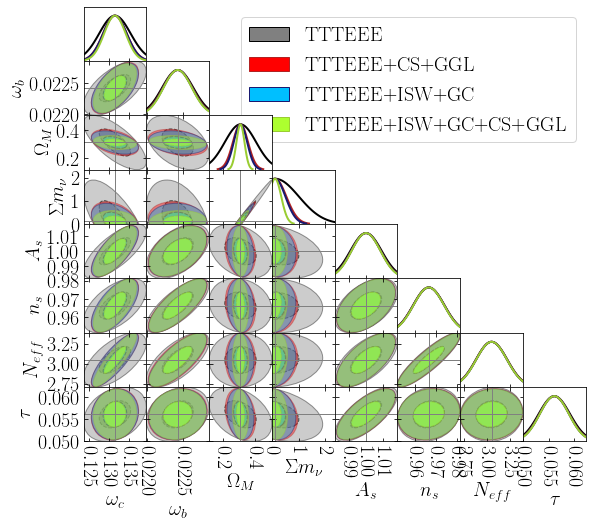

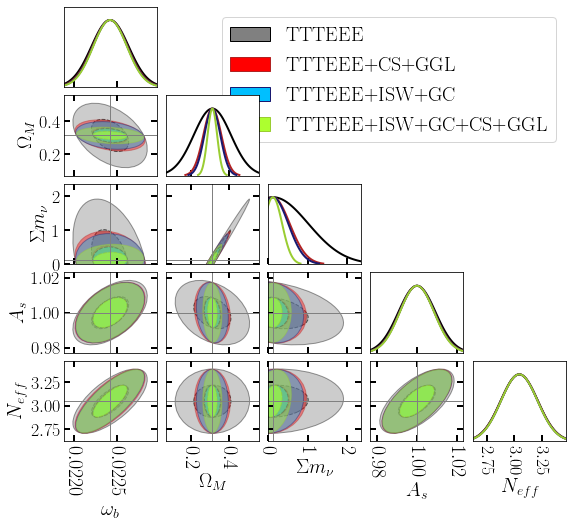

Model & Data sets & $\sigma(\omega_c)$ & $\sigma(\omega_b)$ & $\sigma(\Omega_M)$ & $\sigma(\sigma_8)$ & $\sigma(n_s)$ & $\sigma(\tau)$ & $\sigma(M_\nu)$ & $\sigma(\Neff)$ & $\sigma(w_0)$ & $\sigma(w_a)$ \\
\hline \hline
$\nu \Lambda$CDM & TTTEEE & $ 0.003934 $ & $ 0.000218 $ & $ 0.09731 $ & $ 0.1989 $ & $ 0.007414 $ & $ 0.0031 $ & $ 0.8916 $ & $ 0.1695 $ & $-$ & $-$ \\
\hline
$\nu \Lambda$CDM & TTTEEE+CS+GGL & $ 0.002969 $ & $ 0.0002059 $ & $ 0.04706 $ & $ 0.09405 $ & $ 0.007359 $ & $ 0.002939 $ & $ 0.4235 $ & $ 0.1684 $ & $-$ & $-$ \\
\hline
$\nu \Lambda$CDM & TTTEEE+ISW+GC & $ 0.00295 $ & $ 0.0002017 $ & $ 0.04173 $ & $ 0.08685 $ & $ 0.00731 $ & $ 0.002905 $ & $ 0.3876 $ & $ 0.167 $ & $-$ & $-$ \\
\hline
$\nu \Lambda$CDM & TTTEEE+ISW+GC+CS+GGL & $ 0.002699 $ & $ 0.0001979 $ & $ 0.02497 $ & $ 0.05166 $ & $ 0.007256 $ & $ 0.00288 $ & $ 0.2321 $ & $ 0.1665 $ & $-$ & $-$ \\
\hline


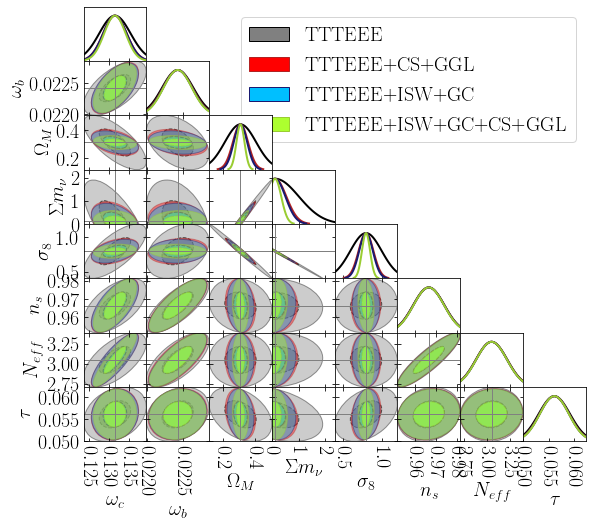

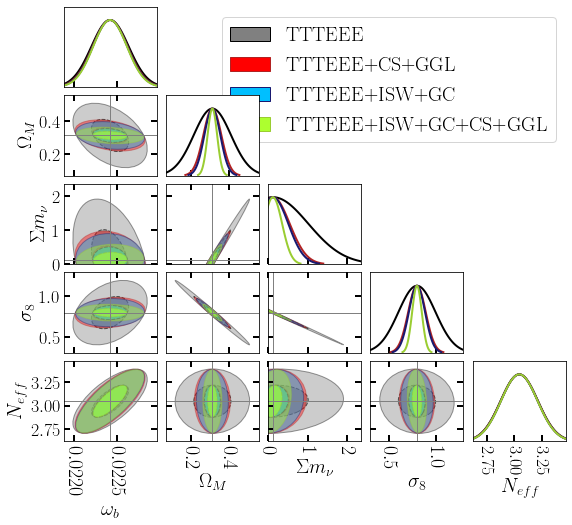

Plotted Matrices


In [9]:
# Plotting Fisher matrix contour corner plots
print("Beginning plots...")

#################
### TOY MODEL ###
#################

# KEY:
# 1. ToySpec - no photometric smearing
# 1. ToyPhot - photometric smearing at least on source galaxies
# 2. LSST - smaller smearing parameter
# 3. Unmargin - Not marginalising over photometric smearing
# 3. Margin - Marginalising over all nuisance parameters
# 3. Opt - No nuisance parameters
# 4. FullPhot - Also photometric smearing on lens galaxies
# 4. NoMult - No multiplicative bias
# 5. 3x2pt
# 5. 1x2pt
# 6. LCDM

# Ordering example:
# FisherMatToyPhotLSSTUnmarginNoMult3x2ptLCDMS8.dat

print("\n\n\n ### TOY MODEL ### \n\n")

print("\n\n\n Spec 3x2pt vs. Photo 3x2pt // DES LCDM\n\n")

# ToySpec3x2ptLCDM vs. ToyPhotMarginFullPhot3x2ptLCDM
FisherMatDES3x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotMarginFullPhot3x2ptLCDM.dat')
FisherMatDES3x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotMarginFullPhot3x2ptLCDMS8.dat')
FisherMat4MOST3x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToySpec3x2ptLCDM.dat')
FisherMat4MOST3x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToySpec3x2ptLCDMS8.dat')
edgecolour = ['firebrick', 'midnightblue']
colour = ['red', 'deepskyblue']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatDES3x2pt)
fisherMatricesAs.append(FisherMat4MOST3x2pt)
fisherMatricesS8.append(FisherMatDES3x2ptS8)
fisherMatricesS8.append(FisherMat4MOST3x2ptS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["Toy Model 3x2pt: Photometric", "Toy Model 3x2pt: Spectroscopic"]
plotFisherMatrices(graphModel=DES3x2ptLCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="PhotoSpec3x2ptLCDMS8.png")

print("\n\n\n Spec 1x2pt vs. LSST 1x2pt vs. DES 1x2pt // DES LCDM\n\n")

# ToySpec1x2ptLCDM vs. ToyPhotLSSTMargin1x2ptLCDM vs. ToyPhotMarginFullPhot1x2ptLCDM
FisherMatDES1x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotMarginFullPhot1x2ptLCDM.dat')
FisherMatDES1x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotMarginFullPhot1x2ptLCDMS8.dat')
FisherMatLSST1x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotLSSTMargin1x2ptLCDM.dat')
FisherMatLSST1x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotLSSTMargin1x2ptLCDMS8.dat')
FisherMat4MOST1x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToySpec1x2ptLCDM.dat')
FisherMat4MOST1x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToySpec1x2ptLCDMS8.dat')
edgecolour = ['firebrick', 'midnightblue', 'yellowgreen']
colour = ['red', 'deepskyblue', 'greenyellow']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatDES1x2pt)
fisherMatricesAs.append(FisherMatLSST1x2pt)
fisherMatricesAs.append(FisherMat4MOST1x2pt)
fisherMatricesS8.append(FisherMatDES1x2ptS8)
fisherMatricesS8.append(FisherMatLSST1x2ptS8)
fisherMatricesS8.append(FisherMat4MOST1x2ptS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["Toy Model 1x2pt: DES", "Toy Model 1x2pt: LSST", "Toy Model 1x2pt: Spectroscopic"]
plotFisherMatrices(graphModel=DES3x2ptLCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="PhotoSpec1x2ptLCDMS8.png")


# s8 contour and multiplicative bias

print("\n\n\n Optimal 1x2pt vs. No multiplicative bias 1x2pt vs. Full 1x2pt // DES LCDM\n\n")

# ToyPhotOpt1x2ptLCDM vs. ToyPhotMarginNoMult1x2ptLCDM vs. ToyPhotMarginFullPhot1x2ptLCDM
FisherMatOpt1x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotOpt1x2ptLCDM.dat')
FisherMatOpt1x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotOpt1x2ptLCDMS8.dat')
FisherMatNoM1x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotMarginNoMult1x2ptLCDM.dat')
FisherMatNoM1x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotMarginNoMult1x2ptLCDMS8.dat')
FisherMatFull1x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotMarginFullPhot1x2ptLCDM.dat')
FisherMatFull1x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotMarginFullPhot1x2ptLCDMS8.dat')
edgecolour = ['firebrick', 'midnightblue', 'yellowgreen']
colour = ['red', 'deepskyblue', 'greenyellow']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatFull1x2pt)
fisherMatricesAs.append(FisherMatNoM1x2pt)
fisherMatricesAs.append(FisherMatOpt1x2pt)
fisherMatricesS8.append(FisherMatFull1x2ptS8)
fisherMatricesS8.append(FisherMatNoM1x2ptS8)
fisherMatricesS8.append(FisherMatOpt1x2ptS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["Toy Model 1x2pt: Full", "Toy Model 1x2pt: -m", "Toy Model 1x2pt: Optimal"]
plotFisherMatrices(graphModel=DES3x2ptLCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="MultiplicativeBias1x2ptLCDMS8.png")

print("\n\n\n Optimal 1x2pt // DES LCDM\n\n")

# ToyPhotOpt1x2ptLCDM vs. ToyPhotMarginNoMult1x2ptLCDM vs. ToyPhotMarginFullPhot1x2ptLCDM
FisherMatOpt1x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotOpt1x2ptLCDM.dat')
FisherMatOpt1x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotOpt1x2ptLCDMS8.dat')
edgecolour = ['firebrick']
colour = ['red']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatOpt1x2pt)
fisherMatricesS8.append(FisherMatOpt1x2ptS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["Toy Model 1x2pt: Optimal"]
plotFisherMatrices(graphModel=DES3x2ptLCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="Optimal1x2ptLCDMS8.png")


model='3x2ptwCDM'
FisherMatDES3x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotMargin3x2ptLCDM.dat')
FisherMatDES3x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToyPhotMargin3x2ptLCDMS8.dat')
FisherMat4MOST3x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToySpec3x2ptLCDM.dat')
FisherMat4MOST3x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatToySpec3x2ptLCDMS8.dat')
edgecolour = ['firebrick', 'midnightblue']
colour = ['red', 'deepskyblue']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatDES3x2pt)
fisherMatricesAs.append(FisherMat4MOST3x2pt)
fisherMatricesS8.append(FisherMatDES3x2ptS8)
fisherMatricesS8.append(FisherMat4MOST3x2ptS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["Toy Model 3x2pt: Photometric", "Toy Model 3x2pt: Spectroscopic"]
plotFisherMatrices(graphModel=DES3x2ptLCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="")

#####################
### DES Vs. 4MOST ###
#####################

# No Planck

print("\n\n\n ##################################### \n\n\n")

print("\n\n\n DES 3x2pt vs. 4MOST+DES 3x2pt // DES wCDM\n\n")
model='3x2ptwCDM'
FisherMatDES3x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatDESLens3x2ptwCDM.dat')
FisherMatDES3x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatDESLens3x2ptwCDMS8.dat')
FisherMat4MOST3x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMat4MOST3x2ptwCDM.dat')
FisherMat4MOST3x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMat4MOST3x2ptwCDMS8.dat')
edgecolour = ['firebrick', 'midnightblue']
colour = ['red', 'deepskyblue']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatDES3x2pt)
fisherMatricesAs.append(FisherMat4MOST3x2pt)
fisherMatricesS8.append(FisherMatDES3x2ptS8)
fisherMatricesS8.append(FisherMat4MOST3x2ptS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["DES 3x2pt", "4MOST+DES 3x2pt"]
plotFisherMatrices(graphModel=DES3x2ptwCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="DES4MOST3x2ptwCDMS8.png")

print("\n\n\n DES 3x2pt vs. 4MOST+DES 3x2pt // DES LCDM\n\n")
model='nuLCDM'
FisherMatDES3x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatDESLens3x2ptLCDM.dat')
FisherMatDES3x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatDESLens3x2ptLCDMS8.dat')
FisherMat4MOST3x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMat4MOST3x2ptLCDM.dat')
FisherMat4MOST3x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMat4MOST3x2ptLCDMS8.dat')
edgecolour = ['firebrick', 'midnightblue']
colour = ['red', 'deepskyblue']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatDES3x2pt)
fisherMatricesAs.append(FisherMat4MOST3x2pt)
fisherMatricesS8.append(FisherMatDES3x2ptS8)
fisherMatricesS8.append(FisherMat4MOST3x2ptS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["DES 3x2pt", "4MOST+DES 3x2pt"]
plotFisherMatrices(graphModel=DES3x2ptLCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="DES4MOST3x2ptLCDMS8.png")

# 1x2pt

print("\n\n\n WL 1x2pt // DES wCDM\n\n")
FisherMatWL1x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatWeakLens1x2ptwCDM.dat')
FisherMatWL1x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatWeakLens1x2ptwCDMS8.dat')
edgecolour = ['firebrick']
colour = ['red']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatWL1x2pt)
fisherMatricesS8.append(FisherMatWL1x2pt)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["DES 1x2pt: Weak Lensing"]
plotFisherMatrices(graphModel=DES3x2ptwCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="WLwCDMS8.png")

print("\n\n\n WL 1x2pt // DES LCDM\n\n")
FisherMatWL1x2pt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatWeakLens1x2ptLCDM.dat')
FisherMatWL1x2ptS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatWeakLens1x2ptLCDMS8.dat')
print(FisherMatWL1x2pt)
edgecolour = ['firebrick']
colour = ['red']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatWL1x2pt)
fisherMatricesS8.append(FisherMatWL1x2ptS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["DES 1x2pt: Weak Lensing"]
plotFisherMatrices(graphModel=DES3x2ptLCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="WLLCDMS8.png")

# With Planck

print("\n\n\n Planck+DES vs. Planck+4MOST+DES // DESnuLCDM\n\n")
model='nuLCDM'
FisherMatCompleteDESLensDES = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFullDESLensDES'+model+'.dat')
FisherMatComplete4MOSTDES = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFullDES'+model+'.dat')
FisherMatCompleteDESLensDESS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFullDESLensDES'+model+'sigma8.dat')
FisherMatComplete4MOSTDESS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFullDES'+model+'sigma8.dat')
edgecolour = ['firebrick', 'midnightblue']
colour = ['red', 'deepskyblue']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatCompleteDESLensDES)
fisherMatricesAs.append(FisherMatComplete4MOSTDES)
fisherMatricesS8.append(FisherMatCompleteDESLensDESS8)
fisherMatricesS8.append(FisherMatComplete4MOSTDESS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["Planck + DES + DES", "Planck + 4MOST + DES"]
plotFisherMatrices(graphModel=DESnuLCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="DES4MOSTnuLCDMS8.png")

print("\n\n\n Planck+DES vs. Planck+4MOST+DES // DESnuwCDM\n\n")
model='nuwCDM'
FisherMatCompleteDESLensDES = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFullDESLensDES'+model+'.dat')
FisherMatComplete4MOSTDES = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFullDES'+model+'.dat')
FisherMatCompleteDESLensDESS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFullDESLensDES'+model+'sigma8.dat')
FisherMatComplete4MOSTDESS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFullDES'+model+'sigma8.dat')
edgecolour = ['firebrick', 'midnightblue']
colour = ['red', 'deepskyblue']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatCompleteDESLensDES)
fisherMatricesAs.append(FisherMatComplete4MOSTDES)
fisherMatricesS8.append(FisherMatCompleteDESLensDESS8)
fisherMatricesS8.append(FisherMatComplete4MOSTDESS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["Planck + DES + DES", "Planck + 4MOST + DES"]
plotFisherMatrices(graphModel=DESnuwCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.3f}", DES=True, extraTxt=r"& $ $ & $ $", saveName="DES4MOSTnuwCDMS8.png")

##############
### nuwCDM ###
##############

model='nuwCDM'
FisherMatPlanck = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+model+'.dat')
FisherMatLens = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+model+'.dat')
FisherMatGal = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+model+'.dat')
FisherMatComplete = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+model+'.dat')
FisherMatPlanckS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+model+'sigma8.dat')
FisherMatLensS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+model+'sigma8.dat')
FisherMatGalS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+model+'sigma8.dat')
FisherMatCompleteS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+model+'sigma8.dat')

print("\n\n\n Planck // nuwCDM\n\n")
edgecolour = ['firebrick']
colour = ['red']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatPlanck)
fisherMatricesS8.append(FisherMatPlanckS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["TTTEEE"]
plotFisherMatrices(graphModel=nuwCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.4}", DES=False, extraTxt="", saveName="PlancknuwCDMS8.png")

print("\n\n\n Plank+DES vs. Planck+4MOST vs. Planck+4MOST+DES // nuwCDM\n\n")
edgecolour = ['firebrick', 'midnightblue', 'yellowgreen']
colour = ['red', 'deepskyblue', 'greenyellow']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatLens)
fisherMatricesAs.append(FisherMatGal)
fisherMatricesAs.append(FisherMatComplete)
fisherMatricesS8.append(FisherMatLensS8)
fisherMatricesS8.append(FisherMatGalS8)
fisherMatricesS8.append(FisherMatCompleteS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["TTTEEE+CS+GGL", "TTTEEE+ISW+GC", "TTTEEE+ISW+GC+CS+GGL"]
plotFisherMatrices(graphModel=nuwCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.4}", DES=False, extraTxt="", saveName="nuwCDMS8.png")

print("\n\n\n Planck+4MOST (Con) vs. Planck+4MOST (Int) // nuwCDM\n\n")
FisherMatGalInt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGalNoNum'+model+'.dat')
FisherMatGalIntS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGalNoNum'+model+'sigma8.dat')
edgecolour = ['firebrick', 'midnightblue']
colour = ['red', 'deepskyblue']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatGal)
fisherMatricesAs.append(FisherMatGalInt)
fisherMatricesS8.append(FisherMatGalS8)
fisherMatricesS8.append(FisherMatGalIntS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["TTTEEE+ISW+GC", "TTTEEE+ISW+GC No number density"]
plotFisherMatrices(graphModel=nuwCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.4}", DES=False, extraTxt="", saveName="GalnuwCDMOptConS8.png")

############
### LCDM ###
############

model='LCDM'
FisherMatPlanck = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+model+'.dat')
FisherMatLens = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+model+'.dat')
FisherMatGal = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+model+'.dat')
FisherMatComplete = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+model+'.dat')
FisherMatPlanckS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+model+'sigma8.dat')
FisherMatLensS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+model+'sigma8.dat')
FisherMatGalS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+model+'sigma8.dat')
FisherMatCompleteS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+model+'sigma8.dat')

print("\n\n\n Planck // LCDM\n\n")
edgecolour = ['firebrick']
colour = ['red']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatPlanck)
fisherMatricesS8.append(FisherMatPlanckS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["TTTEEE"]
plotFisherMatrices(graphModel=LCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.4}", DES=False, extraTxt="", saveName="PlanckLCDMS8.png")

print("\n\n\n Planck vs. Plank+DES vs. Planck+4MOST vs. Planck+4MOST+DES // LCDM\n\n")
edgecolour = ['black', 'firebrick', 'midnightblue', 'yellowgreen']
colour = ['grey', 'red', 'deepskyblue', 'greenyellow']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatPlanck)
fisherMatricesAs.append(FisherMatLens)
fisherMatricesAs.append(FisherMatGal)
fisherMatricesAs.append(FisherMatComplete)
fisherMatricesS8.append(FisherMatPlanckS8)
fisherMatricesS8.append(FisherMatLensS8)
fisherMatricesS8.append(FisherMatGalS8)
fisherMatricesS8.append(FisherMatCompleteS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["TTTEEE", "TTTEEE+CS+GGL", "TTTEEE+ISW+GC", "TTTEEE+ISW+GC+CS+GGL"]
plotFisherMatrices(graphModel=LCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.4}", DES=False, extraTxt="", saveName="LCDMS8.png")

print("\n\n\n Planck+4MOST (Con) vs. Planck+4MOST (Int) // LCDM\n\n")
FisherMatGalInt = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGalNoNum'+model+'.dat')
FisherMatGalIntS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGalNoNum'+model+'sigma8.dat')
edgecolour = ['firebrick', 'midnightblue']
colour = ['red', 'deepskyblue']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatGal)
fisherMatricesAs.append(FisherMatGalInt)
fisherMatricesS8.append(FisherMatGalS8)
fisherMatricesS8.append(FisherMatGalIntS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["TTTEEE+ISW+GC", "TTTEEE+ISW+GC No number density"]
plotFisherMatrices(graphModel=LCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.4}", DES=False, extraTxt="", saveName="GalLCDMOptConS8.png")

############
### wCDM ###
############

model='wCDM'
FisherMatPlanck = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+model+'.dat')
FisherMatLens = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+model+'.dat')
FisherMatGal = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+model+'.dat')
FisherMatComplete = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+model+'.dat')
FisherMatPlanckS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+model+'sigma8.dat')
FisherMatLensS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+model+'sigma8.dat')
FisherMatGalS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+model+'sigma8.dat')
FisherMatCompleteS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+model+'sigma8.dat')

print("\n\n\n Planck vs. Plank+DES vs. Planck+4MOST vs. Planck+4MOST+DES // wCDM\n\n")
edgecolour = ['black', 'firebrick', 'midnightblue', 'yellowgreen']
colour = ['grey', 'red', 'deepskyblue', 'greenyellow']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatPlanck)
fisherMatricesAs.append(FisherMatLens)
fisherMatricesAs.append(FisherMatGal)
fisherMatricesAs.append(FisherMatComplete)
fisherMatricesS8.append(FisherMatPlanckS8)
fisherMatricesS8.append(FisherMatLensS8)
fisherMatricesS8.append(FisherMatGalS8)
fisherMatricesS8.append(FisherMatCompleteS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["TTTEEE", "TTTEEE+CS+GGL", "TTTEEE+ISW+GC", "TTTEEE+ISW+GC+CS+GGL"]
plotFisherMatrices(graphModel=wCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.4}", DES=False, extraTxt="", saveName="wCDMS8.png")

##############
### nuLCDM ###
##############

model='nuLCDM'
FisherMatPlanck = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+model+'.dat')
FisherMatLens = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+model+'.dat')
FisherMatGal = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+model+'.dat')
FisherMatComplete = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+model+'.dat')
FisherMatPlanckS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatPlanck'+model+'sigma8.dat')
FisherMatLensS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatLen'+model+'sigma8.dat')
FisherMatGalS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatGal'+model+'sigma8.dat')
FisherMatCompleteS8 = np.loadtxt(FILEPATH + '/InputFiles/TestingFiles/FisherMatFull'+model+'sigma8.dat')

print("\n\n\n Planck vs. Plank+DES vs. Planck+4MOST vs. Planck+4MOST+DES // nuLCDM\n\n")
edgecolour = ['black', 'firebrick', 'midnightblue', 'yellowgreen']
colour = ['grey', 'red', 'deepskyblue', 'greenyellow']
fisherMatricesAs = []
fisherMatricesS8 = []
fisherMatricesAs.append(FisherMatPlanck)
fisherMatricesAs.append(FisherMatLens)
fisherMatricesAs.append(FisherMatGal)
fisherMatricesAs.append(FisherMatComplete)
fisherMatricesS8.append(FisherMatPlanckS8)
fisherMatricesS8.append(FisherMatLensS8)
fisherMatricesS8.append(FisherMatGalS8)
fisherMatricesS8.append(FisherMatCompleteS8)
fisherMatrices = [fisherMatricesAs, fisherMatricesS8]
legend=["TTTEEE", "TTTEEE+CS+GGL", "TTTEEE+ISW+GC", "TTTEEE+ISW+GC+CS+GGL"]
plotFisherMatrices(graphModel=nuLCDMGraph, fisherMatrices=fisherMatrices, legend=legend, colour=colour, 
                   edgecolour=edgecolour, precsn="{:.4}", DES=False, extraTxt="", saveName="nuLCDMS8.png")

print("Plotted Matrices")
